# Exercício ReACT
  
Aluno: Maria Fernanda Bosco  
RA: 183544  

Fazer um agente que responde perguntas sobre a declaração anual do imposto de renda usando LangChain.
   
Base de dados: https://huggingface.co/datasets/unicamp-dl/BR-TaxQA-R.

Usar questions como base de teste.
Usar referred_legal_documents_QA_2024_v1.0 como base de busca.
  
Busca:
- Embeddings usando FAISS
- Janelamento dos documentos: usar langchain

Avaliação:
- Usar BERTScore para avaliar usando as respostas originais como referência
- Avaliar as referências usadas (F1)
- Avaliar pelo menos as 100 primeiras perguntas.

# Imports

In [ ]:
# Importações necessárias
import os
import json
import numpy as np
import pandas as pd
from typing import List, Dict, Any
from datasets import load_dataset
import datasets
import json

# LangChain imports
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.agents import create_react_agent, AgentExecutor
from langchain.tools import Tool
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Hugging Face e outros
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
import torch
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
import faiss

# Configurações
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

/Users/mabosco/Desktop/mestrado/IA368HH/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SetUp

In [ ]:
# Modelo de embedding
EMBEDDING_MODEL = "multi-qa-mpnet-base-cos-v1"

# Parâmetros de chunking
CHUNK_SIZE = 1000
CHUNK_OVERLAP = 50

# Parâmetros de busca
TOP_K_RETRIEVAL = 3

# OpenAI API
OPENAI_BASE_URL = "https://api.openai.com/v1"
GPT_MODEL = "gpt-5-nano"


# Avaliação
NUM_QUESTIONS = 100

# Arquivos
FAISS_INDEX_PATH = "faiss_index.bin"

# Dados

In [ ]:
# Carregamento do dataset BR-TaxQA-R da Hugging Face
print("Carregando dataset BR-TaxQA-R...")

# Carregar o dataset
dataset = load_dataset(
     "json",
    data_files="data/questions_QA_2024_v1.0.json",
    split="train"
)

print("Dataset carregado!")

# Explorar a estrutura do dataset
print(f"Número de exemplos: {len(dataset)}")
print(f"Colunas: {dataset.column_names}")

# Mostrar um exemplo
if len(dataset) > 0:
        example = dataset[0]
        print(f"Exemplo:")
        for key, value in example.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

Carregando dataset BR-TaxQA-R...
Dataset carregado!
Número de exemplos: 715
Colunas: ['question_number', 'question_summary', 'question_text', 'answer', 'answer_cleaned', 'references', 'linked_questions', 'formatted_references', 'embedded_references', 'formatted_embedded_references', 'all_formatted_references']
Exemplo:
  question_number: 001
  question_summary: OBRIGATORIEDADE
  question_text: Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-cale...
  answer: ['Está obrigada a apresentar a Declaração de Ajuste Anual (DAA) referente ao exercício de 2024, a pessoa', 'física residente no Brasil que, no ano-calendário de 2023:', '1 - recebeu rendimentos tributáveis, sujeitos ao ajuste na declaração, cuja soma foi superior a R$ 30.639,90', '(trinta mil, seiscentos e trinta e nove reais e noventa centavos);', '2 - recebeu rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte, cuja soma foi superior', 'a R$ 200.000,00 (duzent

In [ ]:
print("Carregando base de documentos...")

sources = load_dataset(
    "json",
    data_files="data/referred_legal_documents_QA_2024_v1.0.json",
    split="train"
)

print("Dataset carregado!")

# Explorar a estrutura do dataset
print(f"Número de exemplos: {len(sources)}")
print(f"Colunas: {sources.column_names}")

# Mostrar um exemplo
if len(sources) > 0:
        example = sources[0]
        print(f"Exemplo:")
        for key, value in example.items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

Carregando base de documentos...
Dataset carregado!
Número de exemplos: 478
Colunas: ['filename', 'filedata']
Exemplo:
  filename: ADI RFB nº 12, de 2016.txt
  filedata: NORMAS Contraste   Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado...


In [ ]:
# Selecionar os 100 primeiros itens do dataset
questions_data = dataset.select(range(100))

for item in questions_data:
    # converte a lista answer_cleaned em uma string para ser usada na avaliação
    item['answer_cleaned'] = ' '.join(item['answer_cleaned']).strip()

print("Exemplo de pergunta filtrada:")
print(questions_data[0])

Exemplo de pergunta filtrada:
{'question_number': '001', 'question_summary': 'OBRIGATORIEDADE', 'question_text': 'Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?', 'answer': ['Está obrigada a apresentar a Declaração de Ajuste Anual (DAA) referente ao exercício de 2024, a pessoa', 'física residente no Brasil que, no ano-calendário de 2023:', '1 - recebeu rendimentos tributáveis, sujeitos ao ajuste na declaração, cuja soma foi superior a R$ 30.639,90', '(trinta mil, seiscentos e trinta e nove reais e noventa centavos);', '2 - recebeu rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte, cuja soma foi superior', 'a R$ 200.000,00 (duzentos mil reais);', '3 - obteve, em qualquer mês, ganho de capital na alienação de bens ou direitos sujeito à incidência do imposto;', '4 - realizou operações de alienação em bolsas de valores, de mercadorias, de futuros e assemelhadas:', 'a) cuja soma foi superior a R$ 4

In [ ]:
# Definindo documentos de busca
documents_data = [doc for doc in sources if doc.get('filedata', '').strip()] # remove documentos sem conteúdo

print(f"Total de documentos de busca: {len(documents_data)}")
print(f"Exemplo de documento de busca:")
print(documents_data[0])  # Exemplo de documento de busca

Total de documentos de busca: 478
Exemplo de documento de busca:
{'filename': 'ADI RFB nº 12, de 2016.txt', 'filedata': 'NORMAS Contraste \ue88a \ue8ad Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado(a) no DOU de 25/11/2016, seção 1, página 27) Multivigente Vigente Original Relacional Dispõe sobre a isenção de Imposto sobre a Renda nas aplicações em Certificado de Direitos Creditórios do Agronegócio e Certificado de Recebíveis do Agronegócio. O SECRETÁRIO DA RECEITA FEDERAL DO BRASIL, no uso das atribuições que lhe conferem os incisos III e XXVI do art. 280 do Regimento Interno da Secretaria da Receita Federal do Brasil, aprovado pela Portaria MF n 203, de 14 de maio de 2012, e tendo em vista o disposto no art. 3 da Lei n 11.033, de 21 de dezembro de 2004, e no art. 37 da Lei n 11.076, de 30 de dezembro de 2004, declara: Art. 1 Enquadra-se no conceito de remuneração para fins da isenção prevista no inciso IV do art. 3 da Lei n 11.033, de 21 de dezembro d

# Janelamento de documentos

In [ ]:
print("Implementando janelamento de documentos...")
print("Parâmetros de janelamento: ")
print(f"Tamanho do chunk: {CHUNK_SIZE}")
print(f"Sobreposição entre chunks: {CHUNK_OVERLAP} \n")


# Configurar o text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=CHUNK_SIZE,  # Tamanho do chunk em caracteres
    chunk_overlap=CHUNK_OVERLAP,  # Sobreposição entre chunks
    separators=["\n\n", "\n", ". ", " ", ""]  # Separadores em ordem de preferência
)

# Aplica janelamento nos documentos
print("Aplicando text splitting...")
all_chunks = []
for doc in tqdm(documents_data, desc="Janelamento de documentos"):
    text = doc['filedata']
    chunks = text_splitter.split_text(text)
    for chunk in chunks:
        chunk_text = chunk.strip()
        if chunk_text:
            all_chunks.append({
                'filename': doc['filename'],
                'chunk_text': chunk_text
            })

print(f"\nDocumentos originais: {len(documents_data)}")
print(f"Chunks gerados: {len(all_chunks)}")

# Mostrar estatísticas dos chunks
chunk_lengths = [len(chunk['chunk_text']) for chunk in all_chunks]
print(f"\nEstatísticas dos chunks:")
print(f"  Tamanho médio: {np.mean(chunk_lengths):.1f} caracteres")
print(f"  Tamanho mínimo: {np.min(chunk_lengths)} caracteres")
print(f"  Tamanho máximo: {np.max(chunk_lengths)} caracteres")

# Mostrar alguns exemplos de chunks
print(f"\nExemplos de chunks:")
for i in range(min(3, len(all_chunks))):
    chunk = all_chunks[i]
    print(f"\nChunk {i+1}:")
    print(f"  Tamanho: {len(chunk['chunk_text'])} caracteres")
    print(f"  Documento: {chunk['filename']}")
    print(f"  Conteúdo: {chunk['chunk_text'][:200]}...")

Implementando janelamento de documentos...
Parâmetros de janelamento: 
Tamanho do chunk: 1000
Sobreposição entre chunks: 50 

Aplicando text splitting...


Janelamento de documentos: 100%|██████████| 478/478 [00:00<00:00, 2245.16it/s]


Documentos originais: 478
Chunks gerados: 19083

Estatísticas dos chunks:
  Tamanho médio: 821.4 caracteres
  Tamanho mínimo: 3 caracteres
  Tamanho máximo: 1000 caracteres

Exemplos de chunks:

Chunk 1:
  Tamanho: 829 caracteres
  Documento: ADI RFB nº 12, de 2016.txt
  Conteúdo: NORMAS Contraste   Ato Declaratório Interpretativo RFB nº 12, de 23 de novembro de 2016 (Publicado(a) no DOU de 25/11/2016, seção 1, página 27) Multivigente Vigente Original Relacional Dispõe sobre ...

Chunk 2:
  Tamanho: 807 caracteres
  Documento: ADI RFB nº 12, de 2016.txt
  Conteúdo: . 3 da Lei n 11.033, de 21 de dezembro de 2004, a parcela da variação cambial paga pelo Certificado de Direitos Creditórios do Agronegócio (CDCA) e pelo Certificado de Recebíveis do Agronegócio (CRA) ...

Chunk 3:
  Tamanho: 222 caracteres
  Documento: Acordo para Evitar a Dupla Tributação em Matéria de Impostos sobre a Renda e o Capital firmado entre o Brasil e a Alemanha.txt
  Conteúdo: Ir para o Conteúdo 1 Ir para a Pá

# Embeddings e FAISS

In [ ]:
print("Carregando modelo de embedding...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)  # Carrega o modelo de embedding
print("Modelo de embedding carregado!")

Carregando modelo de embedding...
Modelo de embedding carregado!


In [ ]:
texts_to_emb = [chunk['chunk_text'] for chunk in all_chunks]  # Lista de textos para embedding
print(f"Quantidade de textos para embedding: {len(texts_to_emb)}")

print("Calculando embeddings...")
embeddings = embedding_model.encode(texts_to_emb, show_progress_bar=True).astype('float32') # Calcula os embeddings
print("Embeddings calculados!")

Quantidade de textos para embedding: 19083
Calculando embeddings...


Batches: 100%|██████████| 597/597 [21:01<00:00,  2.11s/it]  


Embeddings calculados!


In [ ]:
print("Criando índice FAISS...")
faiss_index = faiss.IndexFlatIP(embeddings.shape[1])  # Cria um índice FAISS
faiss_index.add(embeddings)  # Adiciona os embeddings ao índice

print("Índice FAISS criado!")
print(f"Quantidade de vetores no índice: {faiss_index.ntotal}")  # Mostra a quantidade de vetores no índice
print(f"Dimensão dos vetores: {faiss_index.d}")  # Mostra a dimensão dos vetores

print("Salvando índice FAISS...")
faiss.write_index(faiss_index, FAISS_INDEX_PATH)  # Salva o índice FAISS em disco
print("Índice FAISS salvo!")

Criando índice FAISS...
Índice FAISS criado!
Quantidade de vetores no índice: 19083
Dimensão dos vetores: 768
Salvando índice FAISS...
Índice FAISS salvo!


In [ ]:
# se precisar carregar FAISS salvo

faiss_index = faiss.read_index(FAISS_INDEX_PATH)

In [ ]:
# definindo funçao de busca com faiss
def search_faiss_top_k(query, faiss_index=faiss_index, k=TOP_K_RETRIEVAL, modelo=embedding_model, chunks=all_chunks):
    # Calcula o embedding da consulta
    q_emb = modelo.encode(query)

    # Ensure proper shape for FAISS (should be 2D array)
    if len(q_emb.shape) == 1:
        q_emb = q_emb.reshape(1, -1)

    # Pesquisa os k vizinhos mais próximos
    distancias, indices = faiss_index.search(q_emb, k)

    # Retorna os k vizinhos mais próximos
    retrieved = [chunks[i] for i in indices[0]]

    return retrieved, indices

In [ ]:
def retriver(query, documents):
    # Pesquisa os documentos mais relevantes
    retrieved, indices = search_faiss_top_k(
        query,
        faiss_index,
        TOP_K_RETRIEVAL,
        embedding_model,
        documents
    )

    context = ""
    references = set()
    for i, doc in enumerate(retrieved):
        context += f"Documento {i+1}:\n"
        context += f"Fonte: {doc['filename']}\n"
        context += f"Texto: {doc['chunk_text']}\n"
        context += "\n"

        references.add(doc['filename'])

    return {"context": context.strip(), "references": list(references)}


In [ ]:
print("Exemplo de busca:\n")
question = questions_data[0]['question_text']
contexto = retriver(question, all_chunks)

print("Pergunta:")
print(question, "\n")

print("Contexto:")
print(contexto['context'])
print("\nReferências:")
print(contexto['references'])  # Exemplo de busca

Exemplo de busca:

Pergunta:
Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023? 

Contexto:
Documento 1:
Fonte: Instrução Normativa RFB nº 2.178.txt
Texto: . 11. A pessoa física sujeita à apresentação da Declaração de Ajuste Anual deve nela relacionar os bens e direitos que, no Brasil ou no exterior, constituíram, em 31 de dezembro de 2022 e em 31 de dezembro de 2023, seu patrimônio e o de seus dependentes relacionados na declaração, e os bens e direitos adquiridos e alienados no decorrer do ano-calendário de 2023. § 1º Devem ser informados, também, as dívidas e os ônus reais existentes em 31 de dezembro de 2022 e em 31 de dezembro de 2023, em nome do declarante e dos seus dependentes relacionados na declaração, e as dívidas e os ônus constituídos ou extintos no decorrer do ano-calendário de 2023. § 2º Os bens e direitos objeto de trust, bem como dos demais contratos regidos por lei estrangeira com caraterísticas similare

# ReACT

In [ ]:
from langchain.chat_models import init_chat_model

In [ ]:
# Ler a chave da API do arquivo 'openai_key.txt'
with open('../openai-key.txt', 'r') as f:
    key = f.read().strip()

os.environ["OPENAI_API_KEY"] = key

# Define modelo LLM
from openai import OpenAI
llm = init_chat_model("openai:gpt-5-nano",
    model_kwargs={
        "response_format": {"type": "json_object"},
        "verbosity": "medium"
    }
)

In [ ]:
# Criar template de prompt para o agente ReACT
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, END
from langchain.tools import tool

react_prompt_template = """Você é um assistente especializado em imposto de renda brasileiro. Sua função é responder perguntas sobre declaração anual de imposto de renda, utilizando a base de conhecimento disponível.

INSTRUÇÕES IMPORTANTES:
1. Use a tool no máximo 2 vezes por pergunta.
2. Baseie suas respostas nas informações encontradas nos documentos.
3. Sempre cite as fontes/referências quando possível.
4. Use linguagem clara e objetiva.
5. Se não tiver certeza da resposta, você pode dizer "não tenho certeza" ou "não sei".

REGRA CRÍTICA: Após 2 buscas, você DEVE dar sua resposta final.

Sua resposta deve ser sempre em JSON, no formato:
{"action":"busca", "query":"pergunta para busca"}
OU
{"action":"resposta", "resposta_final":"sua resposta completa baseada no contexto disponível"}

Se você já tem contexto de busca anterior, analise-o e dê sua resposta final.
Não repita a mesma busca várias vezes.
"""

sys_msg = SystemMessage(content=react_prompt_template)

In [ ]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, END
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain.tools import tool
from pydantic import BaseModel, Field

class RetriverInput(BaseModel):
    """Input schema for the retriver tool."""
    query: str = Field(description="Query to search for relevant Brazilian income tax documents")

@tool(args_schema=RetriverInput)
def retriver_tool(query: str) -> dict:
    """Search for relevant documents about Brazilian income tax declarations.

    This tool searches through legal documents and regulations related to Brazilian
    income tax (IRPF) to find information relevant to the user's query about tax
    declarations, deductions, obligations, and procedures.

    Args:
        query: The search query string to find relevant tax information

    Returns:
        Dictionary containing:
        - context: Formatted text with relevant document excerpts
        - references: List of source document filenames
    """
    return retriver(query, all_chunks)

# Create tools list for ToolNode
tools = [retriver_tool]

llm_with_tools = llm.bind_tools(tools, strict=True)

In [ ]:
def assistant(state: MessagesState):
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)   # Adiciona o nó do assistente
builder.add_node("tools", ToolNode(tools)) # Adiciona o nó das ferramentas
builder.add_edge(START, "assistant")       # Adiciona a aresta do início para o assistente
builder.add_conditional_edges("assistant", tools_condition) # Adiciona arestas condicionais para as ferramentas
builder.add_edge("tools", "assistant")     # Adiciona a aresta das ferramentas para o assistente
graph = builder.compile()

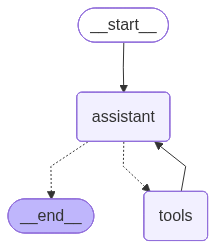

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langchain_core.messages import HumanMessage

messages = [
    HumanMessage(content=questions_data[0]['question_text'])
]

result = graph.invoke({"messages": messages})

for msg in result["messages"]:
    msg.pretty_print()

================================ Human Message =================================

Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?
================================== Ai Message ==================================
Tool Calls:
  retriver_tool (call_4bGRxdxneJkkrbCrBJDXv5p7)
 Call ID: call_4bGRxdxneJkkrbCrBJDXv5p7
  Args:
    query: Quem está obrigado a apresentar a Declaração de Ajuste Anual 2024 ano-calendário de 2023 obrigatoriedade IRPF
================================= Tool Message =================================
Name: retriver_tool

{"context": "Documento 1:\nFonte: Acórdão do RE nº 855.091RS (Tema 808).txt\nTexto: . IncluÃ­do na Lista 28-2021.DT - Agendado para: 05/03/2021\n\nDocumento 2:\nFonte: Lei nº 11.482.txt\nTexto: de 2014 e nos meses de janeiro a março do ano-calendário de 2015: (Redação dada pela Lei nº 13.149, de 2015) Tabela Progressiva Mensal Base de Cálculo (R$) Alíquota (%) Parcela a Deduzir do IR (R$

In [ ]:
result["messages"]

[HumanMessage(content='Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?', additional_kwargs={}, response_metadata={}, id='eebf7d3f-073f-4a8e-9744-f3d920a35a46'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4bGRxdxneJkkrbCrBJDXv5p7', 'function': {'arguments': '{"query":"Quem está obrigado a apresentar a Declaração de Ajuste Anual 2024 ano-calendário de 2023 obrigatoriedade IRPF"}', 'name': 'retriver_tool', 'parsed_arguments': {'query': 'Quem está obrigado a apresentar a Declaração de Ajuste Anual 2024 ano-calendário de 2023 obrigatoriedade IRPF'}}, 'type': 'function'}], 'parsed': None, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 438, 'prompt_tokens': 455, 'total_tokens': 893, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 384, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached

In [ ]:
def getAnswer(result):
    for msg in reversed(result["messages"]):
        if isinstance(msg, AIMessage):
            try:
                data = json.loads(msg.content)
                if data.get("action") == "resposta":
                    #print("Final answer:", data.get("resposta_final"))
                    final_answer = data.get("resposta_final")
                return final_answer
            except Exception:
                continue
print(getAnswer(result))

A Declaração de Ajuste Anual relativa ao exercício de 2024 (ano-calendário de 2023) é obrigatória para o contribuinte que, em 2023, se enquadrar em pelo menos uma das seguintes situações: 1) rendimentos tributáveis recebidos no ano-calendário de 2023 cuja soma foi superior a R$ 28.559,70; 2) rendimentos isentos, não tributáveis ou tributados exclusivamente na fonte cuja soma tenha ficado acima de R$ 40.000,00; 3) bens e direitos com valor de aquisição em 31/12/2023 superiores a R$ 300.000,00; 4) ganhos de capital na alienação de bens sujeitos à tributação; 5) outras situações previstas pela legislação (por exemplo, renda de atividade rural, imóveis no exterior, entre outras hipóteses específicas). Em caso de dúvida, consulte as regras atuais da Receita Federal (Instrução Normativa RFB e guias do IRPF 2024).

Referências:
- Instrução Normativa RFB nº 81 (orienta aspectos da Declaração de Ajuste Anual).
- Lei nº 13.149 (dispositivos que tratam de rendimentos, limites e regras aplicáveis)

In [ ]:
user_question = questions_data[10]['question_text']
result = graph.invoke({"messages": [HumanMessage(content=user_question)]})

In [ ]:
result

{'messages': [HumanMessage(content='Contribuinte com doença grave está desobrigado de apresentar a declaração?', additional_kwargs={}, response_metadata={}, id='962bd652-01e6-48dc-a592-5c4934eec054'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cF7MtPBdHHuaa671htfDj9ow', 'function': {'arguments': '{"query":"doen\\u007fa grave IRPF desobrigado de apresentar a declara\\u007fo?"}', 'name': 'retriver_tool', 'parsed_arguments': {'query': 'doen\x7fa grave IRPF desobrigado de apresentar a declara\x7fo?'}}, 'type': 'function'}], 'parsed': None, 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 879, 'prompt_tokens': 441, 'total_tokens': 1320, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 832, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CQl9gx7Mz1mQ3UIU

In [ ]:
final_answer = getAnswer(result)
final_answer

'Não. A doença grave não gera automaticamente desobrigação de apresentar a Declaração de Ajuste Anual do IRPF. Nas fontes consultadas, não há regra que dispense o contribuinte de declarar apenas por ter doença grave. A doença grave é mencionada em contextos como laudo pericial para rendimentos/pensão (IN RFB nº 1.500) e na possibilidade de deduzir despesas médicas ao declarar (Solução de Consulta Cosit nº 231), mas isso não altera a obrigação de entrega conforme as regras gerais da Receita Federal. Se precisar, posso verificar os critérios específicos de obrigatoriedade para o seu caso. (Fontes: IN RFB nº 1.500; Solução de Consulta Cosit nº 231)'

In [ ]:
type(final_answer)

str

# Avaliação

In [ ]:
def compute_f1_bow(predicted: str, gold: str):
    if not predicted or not gold:
        return 0.0, 0.0, 0.0
    pt = set(predicted.lower().split())
    gt = set(gold.lower().split())
    if not pt and not gt:
        return 1.0, 1.0, 1.0
    if not pt or not gt:
        return 0.0, 0.0, 0.0
    common = pt & gt
    precision = len(common) / len(pt)
    recall = len(common) / len(gt)
    f1 = 0.0 if (precision + recall) == 0 else 2 * (precision * recall) / (precision + recall)
    return precision, recall, f1

In [ ]:
def evaluate_with_react(questions, react_agent, num_questions=NUM_QUESTIONS, verbose=False):
    print(f"🎯 AVALIAÇÃO COM REACT - {num_questions} PERGUNTAS")

    qs = questions.select(range(num_questions))
    gen, ref = [], []
    results = []

    for i, q in enumerate(tqdm(qs, desc="Processando perguntas")):
        print("\n" + "="*70)
        print(f"PERGUNTA {i+1}/{num_questions}")
        qtext = q['question_text']
        print(f"❓ {qtext}")

        rans = q.get('answer_cleaned', '')
        if isinstance(rans, list):
            rans = ' '.join(rans)
        rans = (rans or "").strip()

        try:
            init_state = {"messages": [HumanMessage(content=qtext)]}

            print("🤖 Executando agente...")
            final_state = react_agent.invoke(init_state)

            print("🔍 Extraindo resposta...")
            final_answer = getAnswer(final_state)

            # CORREÇÃO: Garantir que final_answer é string
            if final_answer is None:
                final_answer = ""
            final_answer = str(final_answer)

            print(f"\n📝 RESPOSTA FINAL:\n{final_answer}\n")
            if verbose:
                print(f"📚 REFERÊNCIA:\n{rans}\n")

            # Calcular métricas
            p, r, f1 = compute_f1_bow(final_answer, rans)
            results.append({
                "question": qtext,
                "predicted_answer": final_answer,
                "reference_answer": rans,
                "precision": p,
                "recall": r,
                "f1_bow": f1
            })
            gen.append(final_answer)
            ref.append(rans)

        # se der erro, resposta ficará vazia e métricas zeradas
        except Exception as e:
            print(f"❌ Erro na pergunta {i+1}: {str(e)}")

            results.append({
                "question": qtext,
                "predicted_answer": "",
                "reference_answer": rans,
                "precision": 0.0,
                "recall": 0.0,
                "f1_bow": 0.0
            })
            gen.append("")
            ref.append(rans)

    return results

In [ ]:
def calculate_metrics(results):
    gen = [x['predicted_answer'] for x in results] # respostas geradas
    ref = [x['reference_answer'] for x in results] # respostas de referência

    # BERTScore
    print("\n📊 CALCULANDO BERTSCORE...")
    valid = [(g, r) for g, r in zip(gen, ref) if g.strip() and r.strip()]
    if valid:
        g2, r2 = zip(*valid)
        P, R, F1 = bert_score(list(g2), list(r2), lang='pt', verbose=False)
        p_mean = float(P.mean().cpu().item())
        r_mean = float(R.mean().cpu().item())
        f1_mean = float(F1.mean().cpu().item())
    else:
        p_mean = r_mean = f1_mean = 0.0

    # Estatísticas finais
    f1_bow_scores = [x['f1_bow'] for x in results]
    prec_bow = [x['precision'] for x in results]
    rec_bow = [x['recall'] for x in results]

    print("\n🏆 RESULTADOS FINAIS")
    print(f"Perguntas avaliadas: {len(results)}")
    print("BERTScore:")
    print(f"  Precision: {p_mean:.4f} | Recall: {r_mean:.4f} | F1: {f1_mean:.4f}")
    print("F1-BOW:")
    print(f"  Precision: {np.mean(prec_bow):.4f} | Recall: {np.mean(rec_bow):.4f} | F1: {np.mean(f1_bow_scores):.4f}")

    return

Tive que quebrar o processamento das perguntas de 10 em 10 para conseguir gerar.

In [ ]:
questions_1_10 = questions_data.select(range(10))
results1 = evaluate_with_react(questions_1_10, graph, num_questions=10, verbose=True)

with open("results/results_01.json", "w", encoding="utf-8") as f_json:
    json.dump(results1, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Quem está obrigado a apresentar a Declaração de Ajuste Anual relativa ao exercício de 2024, ano-calendário de 2023?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:51<07:46, 51.85s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
De acordo com a Instrução Normativa RFB nº 2.178, a Declaração de Ajuste Anual relativa ao exercício de 2024 (ano-calendário de 2023) é obrigatória para pessoa física que, em 2023, atenda a qualquer um dos seguintes gatilhos: 1) tenha recebido rendimentos tributáveis sujeitos ao ajuste anual cuja soma tenha sido superior a R$ 5.000.000,00; 2) tenha recebido rendimentos isentos e não tributáveis cuja soma tenha sido superior a R$ 5.000.000,00; 3) tenha recebido rendimentos sujeitos à tributação exclusiva ou definitiva cuja soma tenha sido superior a R$ 5.000.000,00; 4) tenha realizado pagamentos de rendimentos a pessoas físicas ou jurídicas cuja soma tenha sido superior a R$ 5.000.000,00. Além disso, a declaração deve relacionar bens e direitos existentes em 31/12/2022 e 31/12/2023, e as dívidas/ônus existentes nesses mesmos momentos, conforme os §§ do documento 2. Referências: IN RFB nº 2.178 (Documentos 2 e 3).

📚 REFERÊNCIA:
Está obrigada a 

Processando perguntas:  20%|██        | 2/10 [01:24<05:23, 40.40s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. A pessoa física que está desobrigada de apresentar a Declaração de Ajuste Anual (DAA) pode entregá-la de forma voluntária. Isto está previsto na Instrução Normativa RFB nº 2.178, §2º: a pessoa física, ainda que desobrigada, pode apresentar a Declaração de Ajuste Anual, observado o disposto no §3º. Além disso, se houver restituição, o pedido é efetuado por meio de retificação da declaração correspondente (Ato Declaratório SRF nº 3). Em resumo: é possível apresentar a DAA mesmo sem obrigação, e a restituição, se houver, ocorre via retificação. Fontes: Instrução Normativa RFB nº 2.178.txt; Ato Declaratório SRF nº 3.txt.

📚 REFERÊNCIA:
Sim. A pessoa física, ainda que desobrigada, pode apresentar a Declaração de Ajuste Anual (DAA), sendo vedado a um mesmo contribuinte constar simultaneamente em mais de uma Declaração de Ajuste Anual, seja como titular ou dependente, exceto nos casos de alteração na relação de dependência no ano-calendário de 2

Processando perguntas:  30%|███       | 3/10 [02:22<05:40, 48.62s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Ser titular ou sócio de empresa não gera automaticamente a obrigação de apresentar a Declaração de Ajuste Anual do IRPF (exercício 2024). A obrigatoriedade depende das hipóteses previstas para pessoa física, principalmente de rendimentos tributáveis auferidos no ano-base (2023) que atinjam o limite de obrigatoriedade, além de outras situações previstas na legislação (recebimento de rendimentos de fontes diversas, bens/direitos, ganho de capital, etc.). Em caso de empresa inapta e caso o contribuinte não se enquadre em nenhuma outra hipótese de obrigatoriedade, não há obrigação de declarar, e não há aplicação de multa apenas por esse motivo, conforme Súmula CARF nº 42.

Observação: o prazo para a Declaração de Ajuste Anual segue a regra de ser apresentada até o último dia útil de abril do ano subsequente ao da percepção dos rendimentos (ex.: exercícios 2023, entregue em 2024). Fontes: Instrução Normativa RFB nº 2.178; Súmula CARF nº 42; le

Processando perguntas:  40%|████      | 4/10 [03:10<04:50, 48.36s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Participar do quadro societário de uma sociedade anônima ou ser associado de cooperativa em 2023 não, por si só, cria obrigação de entregar a Declaração de Ajuste Anual (DIRPF) do exercício de 2024. A obrigatoriedade depende de critérios da Receita Federal para o IRPF 2024, relacionados aos rendimentos auferidos no ano-calendário de 2023 e a outras situações (por exemplo, rendimentos tributáveis, rendimentos isentos/not tributáveis ou rendimentos sujeitos à tributação exclusiva/definitiva, ou pagamentos de rendimentos a pessoas físicas ou jurídicas acima de determinados valores). Em 2023, a Instrução Normativa RFB nº 2.178 trata dessas hipóteses de obrigatoriedade, incluindo limites de referência (ex.: 5 milhões em certos cenários). Caso você não tenha auferido rendimentos dentro desses limites e não tenha havido outras situações obrigatórias, pode não ser obrigado a declarar. Para confirmar, consulte a seção “Quem precisa declarar” no si

Processando perguntas:  50%|█████     | 5/10 [03:58<04:01, 48.24s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há, nas normas consultadas, uma regra que torne automática a obrigação de entregar a Declaração de Ajuste Anual do exercício de 2024 apenas pelo fato de o contribuinte ter sido responsável perante a Receita Federal pelo CNPJ de associações (ex.: bairros, creches, clubes) no ano-calendário de 2023.

A obrigatoriedade do IRPF 2024 depende de gatilhos pessoais do contribuinte (pessoa física), tais como:
- ter recebido rendimentos tributáveis no ano-calendário 2023 acima do limite de isenção; ou
- possuir rendimentos isentos/not taxed relevantes; ou
- ter ganho de capital, ou possuir bens/direitos com valor total acima de determinado patamar; ou
- outros critérios previstos pela Receita Federal (ex.: atividade rural, dependentes, etc.).

Portanto, apenas ter atuado como responsável de CNPJ de uma associação não implica automaticamente em obrigação de entregar a Declaração de Ajuste Anual. Verifique seus rendimentos e bens pessoais de 2023 e co

Processando perguntas:  60%|██████    | 6/10 [04:25<02:44, 41.09s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não existe limite de idade para a obrigatoriedade ou dispensa de apresentar a Declaração de Ajuste Anual. A obrigatoriedade/dispensa não é definida pela idade, e sim por critérios de renda, bens e outras situações previstas na legislação. Em especial, a dispensa pode ocorrer, por exemplo, quando:
- a pessoa é dependente na declaração de outra pessoa; ou
- os bens comuns já declarados pelo cônjuge/companheiro atendem às condições da norma.
Além disso, a obrigatoriedade é definida pelos limites de rendimentos e ganhos do ano-calendário anterior (por exemplo, rendimentos tributáveis superiores a R$ 30.639,90; rendimentos isentos/não tributáveis superiores a R$ 200.000,00; ganhos de capital; operações na bolsa; atividade rural; etc.), conforme a Instrução Normativa RFB nº 2.178 (para o exercício de 2024). Mesmo desobrigada, a pessoa pode optar por apresentar a declaração.

Referências: Instrução Normativa RFB nº 2.178; Ato Declaratório SRF nº 3.



Processando perguntas:  70%|███████   | 7/10 [04:58<01:54, 38.28s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O critério é estabelecido pela IN RFB nº 2.178: a pessoa física sujeita à Declaração de Ajuste Anual deve relacionar os bens e direitos que, em 31 de dezembro de 2022 e em 31 de dezembro de 2023 (no Brasil ou no exterior), integraram seu patrimônio e o de seus dependentes declarados, bem como os bens adquiridos e alienados no decorrer de 2023. Devem também ser informadas as dívidas/ônus existentes em 31/12/2022 e em 31/12/2023, e os bens no exterior devem ser informados pelo custo de aquisição. Em resumo, para avaliação de bens e direitos, utiliza-se o patrimônio em 31/12/2023 (e, se aplicável, 31/12/2022) mais as transações de 2023. Referência: IN RFB nº 2.178 (Documento 2).

📚 REFERÊNCIA:
É o custo de aquisição. Tratando-se de bens e direitos cuja aquisição tenha ocorrido até 1995, o custo de aquisição pode ser atualizado até 31/12/1995, tomando-se por base o valor da Ufir vigente em 01/01/1996, não se lhe aplicando qualquer atualização a pa

Processando perguntas:  80%|████████  | 8/10 [05:32<01:13, 36.89s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. A obrigação de apresentar a Declaração de Ajuste Anual em relação à atividade rural, conforme a Instrução Normativa RFB nº 2.178, para o exercício de 2024 (referente ao ano-calendário de 2023), está vinculada à obtenção de receita bruta em atividade rural superior a R$ 153.199,50. O texto não estabelece como critério um valor de bens e direitos rurais acima de R$ 800.000,00 (exceto terra nua). Ou seja, possuir bens rurais com valor acima de 800 mil não, por si só, determina a obrigatoriedade; o gatilho é a receita bruta superior a R$ 153.199,50. (Fonte: Instrução Normativa RFB nº 2.178, seção referente à atividade rural)

📚 REFERÊNCIA:
Os bens vinculados à atividade rural, tais como maquinários, semoventes, safra em estoque, não integram o limite para efeito de obrigatoriedade de apresentação da Declaração de Ajuste Anual, exceto para aqueles contribuintes que mantiveram tais bens na Declaração de Bens e Direitos da referida declaração de

Processando perguntas:  90%|█████████ | 9/10 [06:05<00:35, 35.64s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. A Declaração de Ajuste Anual (IRPF) deve ser apresentada pelo contribuinte apenas uma vez no ano, englobando rendimentos de todas as fontes pagadoras. A DIRF, por sua vez, é obrigação da fonte pagadora e informa ao fisco os rendimentos pagos/retidos ao beneficiário (contribuinte), conforme a Solução de Consulta SRRF06Disit nº 6.007/2019. A IN RFB nº 1.500 trata da tributação mensal de determinados rendimentos que podem compor a declaração anual. Em resumo: não é necessária uma DAL (Declaração de Ajuste Anual) separada para cada fonte pagadora; a declaração é consolidada, enquanto as informações de remuneração/retenção vêm das fontes pagadoras via DIRF.

📚 REFERÊNCIA:
Não. O contribuinte deve apresentar somente uma Declaração de Ajuste Anual, independentemente do número de fontes pagadoras, informando todos os rendimentos recebidos durante o ano-calendário de 2023.


PERGUNTA 10/10
❓ Dependente que possui depósito em conta de poupança em v

Processando perguntas: 100%|██████████| 10/10 [06:42<00:00, 40.29s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza, com base apenas nos documentos fornecidos. Os materiais cadastrados (Parecer PGFNCAT nº 1.503/2010; Instrução Normativa RFB nº 1.500; Lei 9.250/95; Decreto 3.000/99) tratam, respectivamente, de dependentes e deduções, bem como das regras de dependência, mas não apresentam o valor-limite atual de bens/direitos que obrigaria um dependente a declarar o IRPF. Portanto, não é possível confirmar, apenas com esses itens, se um dependente com 800 mil em poupança estaria obrigado a declarar. Para confirmar, é necessário consultar a norma vigente para o ano-base (valor de bens e direitos) ou as orientações mais recentes da Receita Federal. Fontes consultadas: Parecer PGFNCAT nº 1.503/2010; Instrução Normativa RFB nº 1.500; Lei 9.250/95; Decreto nº 3.000/99.

📚 REFERÊNCIA:
Está obrigado a apresentar a Declaração de Ajuste Anual (DAA), o contribuinte que, em 31 de dezembro de 2023, teve a posse ou a propriedade de bens e direitos, inclu

In [ ]:
questions_10_20 = questions_data.select(range(10, 20))
results2 = evaluate_with_react(questions_10_20, graph, num_questions=10, verbose=True)

with open("results/results_02.json", "w", encoding="utf-8") as f_json:
    json.dump(results2, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Contribuinte com doença grave está desobrigado de apresentar a declaração?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:28<04:19, 28.85s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não é automático. A doença grave pode prever isenção de Imposto de Renda sobre determinados proventos (por exemplo, aposentadoria ou reforma motivada por acidente em serviço, ou para portadores de moléstia grave), conforme a Lei nº 7.713, inciso XIV (redação atual). Porém, isso não desobriga automaticamente o contribuinte de apresentar a declaração anual do IRPF. A obrigatoriedade de declarar depende do conjunto de rendimentos e de outros critérios da Receita Federal (rendimentos tributáveis, bens, ganhos de capital, etc.). Se todos os seus rendimentos forem isentos por doença grave e, somados, ficarem abaixo do limite de obrigatoriedade, pode não haver necessidade de declarar; caso contrário, a declaração é necessária para cumprir a lei. Referência: Lei nº 7.713, XIV (isenção de IR sobre proventos de aposentadoria/reforma para portadores de moléstia grave).

📚 REFERÊNCIA:
Não. A isenção relativa à doença grave especificada em lei não desobrig

Processando perguntas:  20%|██        | 2/10 [00:55<03:42, 27.80s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Opção pelo desconto simplificado é a escolha na Declaração de Ajuste Anual (IRPF) que faz o contribuinte para aplicar uma dedução fixa. Ela substitui todas as deduções permitidas pela legislação e corresponde à dedução de 20% do valor dos rendimentos tributáveis na declaração, independentemente do montante desses rendimentos, dispensando a comprovação de despesas e a indicação de sua espécie. Existe um teto máximo previsto pela legislação (Lei n° 9.250/1995). Essa opção pode ser feita na própria DAA, sem necessidade de comprovar despesas específicas. (Fontes: Decreto n° 9.580/2018; Instrução Normativa RFB n° 1.500/2017; Lei n° 9.250/1995)

📚 REFERÊNCIA:
A opção pelo desconto simplificado implica a substituição de todas as deduções admitidas na legislação tributária, correspondente à dedução de 20% do valor dos rendimentos tributáveis na Declaração de Ajuste Anual, limitado a R$ 16.754,34 (dezesseis mil, setecentos e cinquenta e quatro reais e 

Processando perguntas:  30%|███       | 3/10 [01:25<03:19, 28.49s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Conforme a Solução de Consulta Interna COSIT nº 29, de 2013, o desconto simplificado substitui as deduções legais, mas não impede que o outro cônjuge utilize deduções legais, incluindo o dependente comum na declaração dele, e vice-versa. Além disso, o Decreto nº 9.580/2018 estabelece que os dependentes comuns ao casal podem ser considerados na base de cálculo de apenas um dos cônjuges, vedada a concomitância da dedução para o mesmo dependente. Portanto, se um cônjuge usa o desconto simplificado e não inclui o dependente, o outro pode incluí-lo em suas deduções legais, desde que o dependente não seja deduzido por ambos na mesma declaração.

📚 REFERÊNCIA:
Sim. A apresentação de declaração com opção pelo desconto simplificado por um dos cônjuges ou companheiros, em que não há a inclusão de dependente comum, não impede que o outro cônjuge ou companheiro apresente declaração com a utilização das deduções legais, incluindo o dependente comum na

Processando perguntas:  40%|████      | 4/10 [02:01<03:09, 31.66s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O desconto simplificado na Declaração de Ajuste Anual (IRPF) é uma opção disponível para pessoa física residente que entrega a declaração. Em linhas gerais, trata-se de uma forma de deduzir o imposto devido sem itemizar despesas, aplicando um benefício fixo de 20% sobre o imposto, com um limite anual, substituindo as deduções detalhadas (despesas com saúde, educação, dependentes, etc.). Observação: não consegui localizar nos documentos disponíveis uma referência oficial que descreva as regras atuais com precisão; recomendo consultar a Instrução Normativa da Receita Federal (RFB) ou o próprio programa da declaração para confirmar elegibilidade e o limite vigente.

📚 REFERÊNCIA:
Qualquer contribuinte pode optar pelo desconto simplificado. Entretanto, após o prazo para a apresentação da declaração, não será admitida a mudança na forma de tributação de declaração já apresentada.


PERGUNTA 5/10
❓ O contribuinte que possui mais de uma fonte pagador

Processando perguntas:  50%|█████     | 5/10 [02:28<02:29, 29.89s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. O desconto simplificado pode ser utilizado pela fonte pagadora de forma mensal, quando isso for mais benéfico ao contribuinte. Segundo a Instrução Normativa RFB nº 1.500, §3, a fonte pagadora poderá aplicar o desconto simplificado mensal, correspondente a 25% (vinte e cinco por cento) do valor máximo da faixa com alíquota de 0% (zero por cento) da tabela progressiva mensal, dispensando a comprovação da despesa e a indicação de sua espécie. Isso pode ocorrer mesmo se o contribuinte tiver mais de uma fonte pagadora, desde que seja mais benéfico ao contribuinte. (Referência: IN RFB nº 1.500, §3)

📚 REFERÊNCIA:
Sim. O contribuinte que possui mais de uma fonte pagadora pode optar pelo desconto simplificado. Ele deve preencher a Declaração de Ajuste Anual, informando nos campos pertinentes os nomes e os números de inscrição no Cadastro Nacional da Pessoa Jurídica (CNPJ) ou no Cadastro de Pessoas Físicas (CPF) de todas as fontes, bem como indica

Processando perguntas:  60%|██████    | 6/10 [03:14<02:21, 35.46s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há informação clara nos documentos fornecidos de que haja restrição explícita ao uso do desconto simplificado quando há prejuízo na atividade rural. Os materiais indicam apenas: (a) o resultado da atividade rural pode ser negativo e pode ser compensado nos anos-calendário seguintes (Instrução Normativa RFB nº 83, art. 11, §1º); (b) para compensação de prejuízo acumulado, é necessária escrituração (art. 13) e a separação de resultados entre unidades rurais (arts. 14-16). Não há menção específica ao desconto simplificado no contexto da atividade rural ou de prejuízos. Portanto, com base nesses documentos, não é possível confirmar se o contribuinte pode optar pelo desconto simplificado no ano-base 2023. Recomenda-se consultar a orientação atual da Receita Federal sobre a opção pelo desconto simplificado na declaração do IRPF (ano-base correspondente) e considerar se a compensação de prejuízos rurais impacta essa opção. Referências: Instrução 

Processando perguntas:  70%|███████   | 7/10 [03:51<01:47, 35.91s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza, com base nas fontes fornecidas não há uma instrução explícita sobre o tratamento do Desconto Simplificado em relação ao preenchimento das fichas 'Pagamentos Efetuados' e 'Doações Efetuadas'. Os trechos disponíveis indicam que pagamentos e doações devem ser informados e comprovados, mas não afirmam se isso é obrigatório quando o contribuinte opta pelo desconto simplificado (dedução padrão). Recomenda-se consultar as instruções oficiais da Receita Federal ou o programa IRPF atualizado para confirmar o tratamento específico do Desconto Simplificado. Fontes consideradas: Decreto nº 9.580, de 22 de novembro de 2018 (artigos sobre Pagamentos Efetuados e Doações) e IN RFB nº 1.717.

📚 REFERÊNCIA:
Independentemente da forma de tributação escolhida pelo contribuinte, deve-se preencher as fichas “Pagamentos Efetuados” e “Doações Efetuadas” incluindo todos os pagamentos e doações efetuados a: - pessoas físicas, tais como pensão aliment

Processando perguntas:  80%|████████  | 8/10 [04:20<01:07, 33.62s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza. Com base nas fontes consultadas (Decreto nº 9.580/2018; Lei nº 13.043; Resolução CGSN nº 140/2018), não há texto claro que afirme que o Desconto Simplificado substitui a parcela de isenção relacionada a rendimentos de aposentadoria para contribuintes com 65 anos ou mais. O Desconto Simplificado é uma dedução padrão (20% dos rendimentos) com teto, e a eventual isenção para maiores de 65 anos, quando existente na norma vigente, costuma atuar de forma separada. Para confirmação definitiva, consulte o manual/guia da Receita Federal correspondente à temporada atual do IRPF.

📚 REFERÊNCIA:
Não. A parcela isenta referente a rendimentos de aposentadoria recebidos por contribuinte maior de 65 anos deve ser informada na Declaração de Ajuste Anual na ficha correspondente aos Rendimentos Isentos e Não Tributáveis. O desconto simplificado aplica-se apenas aos rendimentos tributáveis e substitui as deduções legais cabíveis, limitado a R$ 

Processando perguntas:  90%|█████████ | 9/10 [04:59<00:35, 35.51s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. No Desconto Simplificado do IRPF (modelo simplificado), a dedução é uma parcela fixa de 20% da renda tributável, com teto máximo anual. Esse regime não permite excluir ou deduzir despesas específicas, como honorários advocatícios pagos em decorrência de rendimentos recebidos acumuladamente por decisão judicial. Se desejar deduzir despesas específicas, o contribuinte precisa optar pelo modelo completo da declaração, onde as deduções são distintas das do desconto simplificado. Consulte a norma vigente e a Receita Federal para confirmar os valores e regras atualizados do ano-base.

📚 REFERÊNCIA:
Sim. O contribuinte, independentemente da opção pelo desconto simplificado ou não, pode informar como rendimento tributável o valor recebido, excluindo os honorários pagos na proporção dos rendimentos tributáveis.


PERGUNTA 10/10
❓ O contribuinte que optar pelo desconto simplificado pode excluir as despesas com condomínio, taxas, impostos, em relaçã

Processando perguntas: 100%|██████████| 10/10 [05:44<00:00, 34.46s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Ao optar pelo desconto simplificado na declaração do IRPF, você não pode deduzir despesas específicas relacionadas a aluguéis (condomínio, taxas, IPTU, impostos, etc.). O desconto simplificado é uma dedução padrão de 20% sobre os rendimentos tributáveis, com limite máximo, e não permite a dedução de despesas itemizadas. Se desejar descontar essas despesas, seria necessário optar pela declaração completa, conforme as regras da Receita Federal.

📚 REFERÊNCIA:
Sim. O contribuinte, independentemente da opção pelo desconto simplificado ou não, deve informar como rendimento tributável o valor dos aluguéis recebidos, podendo excluir os impostos, as taxas e os emolumentos incidentes sobre o bem que produzir o rendimento, desde que o ônus desses encargos tenha sido exclusivamente do declarante.



In [ ]:
questions_20_30 = questions_data.select(range(20, 30))
results3 = evaluate_with_react(questions_20_30, graph, num_questions=10, verbose=True)

with open("results/results_03.json", "w", encoding="utf-8") as f_json:
    json.dump(results3, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Qual é o prazo de apresentação da Declaração de Ajuste Anual do exercício de 2024?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:23<03:28, 23.20s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza do prazo específico para o exercício de 2024 com base nos documentos fornecidos. Nas fontes apresentadas, o prazo original de entrega da Declaração de Ajuste Anual foi prorrogado para 31 de maio nos exercícios de 2021, 2022 e 2023 (conforme a Instrução Normativa RFB nº 81). Não há menção ao prazo de 2024 nesses trechos. Para confirmar o prazo de 2024, consulte a Instrução Normativa RFB vigente para o IRPF 2024 ou o site da Receita Federal (Acervo IRPF/Imposto de Renda) e busque o comunicado oficial com o prazo de entrega. Referências: Instrução Normativa RFB nº 81.txt (prorrogações até 31/05 para 2021–2023).

📚 REFERÊNCIA:
A Declaração de Ajuste Anual (DAA) deve ser apresentada no período de 15 de março a 31 de maio de 2024. O serviço de recepção da declaração, pela Internet, será interrompido às 23h59min59s (vinte e três horas, cinquenta e nove minutos e cinquenta e nove segundos), horário de Brasília, do último dia do prazo

Processando perguntas:  20%|██        | 2/10 [00:57<03:59, 29.94s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para a pessoa física ausente do Brasil, o prazo de apresentação da Declaração de Ajuste Anual (IRPF) é o mesmo das demais pessoas físicas residentes no Brasil. De acordo com a Instrução Normativa RFB nº 208, art. 12, a pessoa física ausente no exterior a serviço do Brasil mantém a condição de residente e sujeita à Declaração de Ajuste Anual segundo as mesmas normas aplicáveis aos demais contribuintes.

Portanto, o prazo normalmente é até 30 de abril do ano seguinte ao ano-calendário (com possíveis prorrogações excepcionais definidas pela Receita Federal em casos específicos).

Fontes: Instrução Normativa RFB nº 208 (art. 12) e referência a flexibilizações de prazo em situações excepcionais.

📚 REFERÊNCIA:
A pessoa física que se encontra no exterior deve apresentar sua declaração até 31 de maio de 2024.


PERGUNTA 3/10
❓ Contribuinte que na data final da apresentação da declaração se encontra em viagem, fora de seu domicílio fiscal, tem direito

Processando perguntas:  30%|███       | 3/10 [01:23<03:16, 28.03s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não encontrei nas fontes consultadas uma regra que garanta prorrogação automática do prazo da Declaração do Imposto de Renda da Pessoa Física (IRPF) apenas pelo fato de o contribuinte estar em viagem na data de vencimento. As fontes pesquisadas (ex.: Solução de Consulta Cosit n° 261/2017; Nota PGFN CRJ n° 1.040/2015; Instrução Normativa RFB n° 1.717/2018) tratam de outros temas e não confirmam esse direito. Recomenda-se confirmar nos regulamentos mais recentes da Receita Federal ou com um profissional, já que pode haver regras específicas não cobertas pelas fontes acima. Se quiser, posso buscar informações atualizadas sobre prorrogações ou situações excepcionais para entrega da IRPF.

📚 REFERÊNCIA:
Não. Recomenda-se que o contribuinte apresente sua declaração no prazo legal, no local onde se encontrar, indicando, no campo próprio, seu domicílio fiscal permanente.


PERGUNTA 4/10
❓ Qual é a penalidade aplicável na apresentação da Declaração de 

Processando perguntas:  40%|████      | 4/10 [01:41<02:24, 24.16s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
A penalidade aplicável é a multa por atraso ou não apresentação da Declaração de Ajuste Anual, conforme a Instrução Normativa RFB nº 2.178:
- Valor: 1% (um por cento) ao mês-calendário ou fração de atraso, lançada de ofício e calculada sobre o total do imposto devido nela apurado, ainda que integralmente pago;
- Limites: valor mínimo de R$ 165,74 e valor máximo de 20% do Imposto de Renda devido;
- Vigência do período de aplicação: o termo inicial é o 1º dia subsequente ao término do prazo para entrega; o termo final é o mês em que a declaração foi entregue ou, se não entregue, a data do lançamento de ofício.
Observação: aplica-se quando a declaração é obrigatória e não é apresentada ou é apresentada com atraso.
Fonte: Instrução Normativa RFB nº 2.178.

📚 REFERÊNCIA:
O contribuinte obrigado a apresentar a declaração, no caso de apresentação após o prazo previsto ou da não apresentação, fica sujeito ao pagamento de multa por atraso, calculada da

Processando perguntas:  50%|█████     | 5/10 [02:15<02:17, 27.46s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. A multa por atraso na entrega da Declaração de Ajuste Anual aplica-se aos contribuintes que são obrigados a apresentar a declaração. Pessoas físicas que se enquadram na dispensa (ou seja, não estão obrigadas a entregar a Declaração de Ajuste Anual) não estão sujeitas à multa de atraso por não apresentar. Isso está previsto na Instrução Normativa RFB nº 2.178, que trata das hipóteses de dispensa da obrigatoriedade de entrega. Caso a pessoa desobrigada opte por apresentar a declaração, aplicam-se as regras normais de entrega e possíveis ajustes conforme o caso.

📚 REFERÊNCIA:
Não é devida a multa por atraso na entrega da declaração para quem está desobrigado de apresentar a Declaração de Ajuste Anual.


PERGUNTA 6/10
❓ De quais formas posso preencher a Declaração de Ajuste Anual (DAA) do ano-calendário de 2023, exercício de 2024?
🤖 Executando agente...


Processando perguntas:  60%|██████    | 6/10 [02:42<01:49, 27.39s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Formas de preenchimento da Declaração de Ajuste Anual (DAA) do ano-calendário 2023, exercício 2024:

1) PGD (Programa Gerador de Declaração) — preencher no computador com o PGD, gravar o arquivo e transmitir pela Internet usando o ReceitaNet.
2) Declaração de Ajuste Anual Pré-Preenchida (DAA Pré-Preenchida) — disponível no portal gov.br com autenticação por Identidade Digital Ouro ou Prata (ou por procuração/RFB). O contribuinte verifica os dados pré-preenchidos, faz as alterações/inclusões/exclusões necessárias e envia.
3) Pela Internet, no período 15/03/2024 a 31/05/2024, utilizando as opções previstas pela norma (PGD ou DAA Pré-Preenchida) com envio pela Internet conforme as regras da IN RF B n° 2.178.

Observação: a transmissão costuma ocorrer via ReceitaNet, conforme os canais oficiais citados.

Referências: Instrução Normativa RFB nº 2.178; Conteúdos sobre PGD, DAA Pré-Preenchida e envio pela ReceitaNet (documentos citados).

📚 REFERÊNCI

Processando perguntas:  70%|███████   | 7/10 [03:02<01:15, 25.01s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Pode apresentar a Declaração de Ajuste Anual:
- pelo próprio contribuinte; ou
- por representante do contribuinte que possua procuração RFB ou procuração eletrônica (nos termos da Instrução Normativa RFB nº 2.066/2022); ou
- por pessoa física autorizada, nos termos do art. 14, § 3º.
Essa possibilidade está prevista na Declaração de Ajuste Anual Pré-Preenchida, conforme IN RFB nº 2.178.

📚 REFERÊNCIA:
Podem elaborar, transmitir a Declaração de Ajuste Anual (DAA), inclusive acessar os dados da DAA Pré- preenchida: 1. o representante do contribuinte com procuração RFB ou procuração eletrônica, nos termos da Instrução Normativa RFB nº 2.066, de 24 de fevereiro de 2022; ou 2. a pessoa física autorizada pelo contribuinte desde que as pessoas físicas autorizadora e autorizada possuam conta com Identidade Digital gov.br nos níveis Ouro ou Prata. Atenção: A autorização: I – pode ser concedida somente a uma única pessoa física; II – é válida por até 6 (

Processando perguntas:  80%|████████  | 8/10 [03:22<00:46, 23.40s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para acessar a Declaração de Ajuste Anual Pré-Preenchida (DAA Pré-Preenchida), siga estas orientações:

1) Acesse o portal único gov.br e faça login com Identidade Digital Ouro ou Prata. 
2) A DAA Pré-Preenchida pode ser obtida por meio dessa autenticação: • do contribuinte; • do representante do contribuinte com procuração RFB ou procuração eletrônica; ou • de pessoa física autorizada, nos termos do art. 14, § 3º. 
3) A DAA Pré-Preenchida contém informações sobre rendimentos, deduções, bens e direitos, dívidas e ônus reais, e pode ser utilizada para a elaboração de uma nova Declaração de Ajuste Anual. 
4) A verificação da correção de todos os dados pré-preenchidos é de responsabilidade do contribuinte, que deve realizar alterações, inclusões ou exclusões quando necessário. 
5) Observação de contexto (prazo de entrega): a declaração deve ser apresentada pela Internet no período indicado pelo regulamento, geralmente dentro da janela de 15 de ma

Processando perguntas:  90%|█████████ | 9/10 [03:41<00:22, 22.15s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
A Declaração de Ajuste Anual Pré-Preenchida contém informações relativas a rendimentos, deduções, bens e direitos e dívidas e ônus reais. Pode ser obtida no portal gov.br com Identidade Digital Ouro ou Prata, e a verificação/ajuste dos dados é de responsabilidade do contribuinte. (Fonte: Instrução Normativa RFB nº 2.178)

📚 REFERÊNCIA:
A Declaração de Ajuste Anual Pré-Preenchida contém algumas informações relativas a rendimentos, deduções, bens e direitos e dívidas e ônus reais constantes nos sistemas da Secretaria Especial da Receita Federal do Brasil (RFB), decorrentes das informações prestadas pelas fontes pagadoras ou pelas pessoas jurídicas ou equiparadas, referentes ao exercício de 2024, ano-calendário de 2023, por meio, dentre outros: I – da Declaração do Imposto sobre a Renda Retido na Fonte (Dirf); II – da Declaração de Serviços Médicos e de Saúde (Dmed); III – da Declaração de informações sobre Atividades Imobiliárias (Dimob); IV – d

Processando perguntas: 100%|██████████| 10/10 [04:06<00:00, 24.65s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Pode utilizar a Declaração de Ajuste Anual Pré-Preenchida: 1) o próprio contribuinte (pessoa física); 2) o representante do contribuinte, mediante procuração RFB ou procuração eletrônica, nos termos da Instrução Normativa RFB nº 2.066; 3) pessoa física autorizada nos termos do art. 14, §3º. A pré-preenchida pode ser obtida no portal gov.br com Identidade Digital Ouro ou Prata. (Fonte: Instrução Normativa RFB nº 2.178, §2º e §3º).

📚 REFERÊNCIA:
A Declaração de Ajuste Anual Pré-Preenchida poderá ser obtida por meio de autenticação no portal gov.br, com Identidade Digital Ouro ou Prata: I – do contribuinte; II – do representante do contribuinte com procuração RFB ou procuração eletrônica, obedecendo ao disposto nos arts. 6º a 10 da Instrução Normativa RFB nº 2.066, de 24 de fevereiro de 2022; ou III – de pessoa física autorizada pelo contribuinte (consulte a Pergunta 027)



In [ ]:
questions_30_40 = questions_data.select(range(30, 40))
results4 = evaluate_with_react(questions_30_40, graph, num_questions=10, verbose=True)

with open("results/results_04.json", "w", encoding="utf-8") as f_json:
    json.dump(results4, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Quem não pode preencher ou apresentar a declaração por meio do “Meu Imposto de Renda”?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:31<04:47, 31.91s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
A vedação está prevista na Instrução Normativa RFB nº 2.178, art. 5º: ficam vedados o preenchimento e a apresentação da Declaração de Ajuste Anual por meio do "Meu Imposto de Renda". Em outras palavras, há situações em que esse canal não pode ser utilizado. Para saber exatamente quem não pode, é necessário consultar o texto completo do art. 5º da IN RFB nº 2.178. Fontes: Instrução Normativa RFB nº 2.178, art. 5º.

📚 REFERÊNCIA:
É vedado o preenchimento e a apresentação da declaração por meio do “Meu Imposto de Renda”, consulte o item II da Pergunta 026, nas hipóteses de os declarantes ou seus dependentes informados nessa declaração, no ano-calendário de 2023: I – terem recebido rendimentos do exterior; II – terem auferido os seguintes rendimentos sujeitos à tributação exclusiva ou definitiva: a) ganhos de capital na alienação de bens ou direitos; b) ganhos de capital na alienação de bens, direitos e aplicações financeiras adquiridos em moeda e

Processando perguntas:  20%|██        | 2/10 [01:00<03:59, 29.96s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Você pode obter o Programa IRPF 2024 (Programa Gerador da Declaração do IRPF) no site da Receita Federal do Brasil. Acesse http://www.receita.fazenda.gov.br, vá à seção de Declarações/IRPF ou Downloads de Programas e baixe o exercício 2024 (Programa Gerador da Declaração). O software é disponibilizado pela Receita Federal pela internet (orientações oficiais citadas em documentos institucionais). 

Fontes consultadas: Declaração de Imposto de Renda Retido na Fonte (DIRF).txt e Instrução Normativa RFB nº 208.txt, que mencionam a disponibilidade do programa na Internet por meio do site da Receita Federal.

📚 REFERÊNCIA:
O programa IRPF 2024 para a Declaração de Ajuste Anual pode ser obtido no site da Secretaria Especial da Receita Federal do Brasil (RFB) na Internet, no endereço http://www.gov.br/receitafederal/pt-br. Localize o programa IRPF 2024 a partir da barra de menu na opção “Meu Imposto de Renda”, procure por “IRPF 2024” e selecione "Down

Processando perguntas:  30%|███       | 3/10 [01:25<03:12, 27.53s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza. Os documentos fornecidos nas buscas não apresentam requisitos técnicos ou de sistema para utilização do Programa IRPF 2024 (PGD IRPF 2024). Eles tratam de temas fiscais, isenções, decretos e instruções normativas, mas não especificam hardware, sistema operacional ou versões de software.

Para obter os requisitos oficiais, consulte fontes oficiais da Receita Federal do Brasil, como:
- Página da Receita Federal: IRPF 2024 > Programas/Downloads > Programa Gerador da Declaração (PGD IRPF 2024) e guias de instalação;
- Manuais e notas técnicas disponibilizados com o PGD IRPF 2024.

Fontes utilizadas nas buscas: Nota PGFN CRJ nº 1.104 2017.txt, Instrução Normativa RFB nº 1.997, de 21 de novembro de 2019.txt, Decreto nº 85.306.txt.

📚 REFERÊNCIA:
O PGD foi desenvolvido em Java multiplataforma e pode ser executado em diversos sistemas operacionais (Linux, Windows e Mac). Não há mais a necessidade de o contribuinte instalar uma versã

Processando perguntas:  40%|████      | 4/10 [01:53<02:46, 27.75s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O IRPF 2024 utiliza o Programa Gerador de Declaração (PGD) para preencher a declaração e, após preenchimento, enviar à Receita Federal pelo programa ReceitaNet. Os trechos disponíveis não trazem etapas de instalação nem requisitos de sistema. Para instalar/baixar o PGD 2024, acesse o site oficial da Receita Federal (Portal IRPF) e siga as instruções fornecidas lá; o serviço de transmissão via ReceitaNet é gratuito. Fontes: Declaração de Benefícios Fiscais (DFB).txt; Instrução Normativa RFB nº 1.343.txt.

📚 REFERÊNCIA:
1 - Acesse o site da Secretaria Especial da Receita Federal do Brasil (RFB) na Internet, no endereço http://www.gov.br/receitafederal/pt-br; 2 - Localize o programa IRPF 2024 na opção “Meu Imposto de Renda”; 3 – Siga as orientações para download constantes no site da RFB na Internet.


PERGUNTA 5/10
❓ Quais são os meios a serem utilizados para transmissão da Declaração de Ajuste Anual do ano-calendário de 2023, exercício de 2024?

Processando perguntas:  50%|█████     | 5/10 [02:25<02:26, 29.37s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Os meios para transmissão da Declaração de Ajuste Anual do ano-calendário de 2023, exercício de 2024, são:
- Transmissão pela Internet: por meio do Programa Gerador da Declaração (PGD IRPF) disponível no site da Receita Federal, transmitindo a declaração pela internet.
- Entrega em mídia removível: caso não seja possível a transmissão pela Internet, a declaração pode ser apresentada em mídia removível (disquete/CD/DVD) nas unidades da Secretaria da Receita Federal.
Estas possibilidades são referidas nas normativas da Receita Federal, que descrevem a transmissão pela Internet e a apresentação em mídia removível como vias de entrega.
Referências: Instrução Normativa RFB nº 81.txt (dispositivos sobre transmissão pela Internet e apresentação em mídia removível); documentação do PGD IRPF disponível no site da Receita Federal.

📚 REFERÊNCIA:
A Declaração de Ajuste Anual deve ser apresentada no período de 15 de março a 31 de maio de 2024, pela Intern

Processando perguntas:  60%|██████    | 6/10 [02:44<01:43, 25.76s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para obter mais informações sobre a transmissão da declaração pela Internet usando o Receitanet, utilize os canais oficiais da Receita Federal:

- Site da Receita Federal: http://www.receita.fazenda.gov.br — contém informações gerais sobre o Receitanet, o PGD (Programa Gerador de Declaração) e o envio das declarações (IRPF, DMED, DFB, etc.).
- ReceitaNet e PGD: o ReceitaNet valida e transmite, via Internet, as declarações de impostos e contribuições federais. Os arquivos podem ser transmitidos diariamente das 05:00 às 01:00 do dia seguinte. 
- Fale Conosco: para dúvidas, reclamações ou sugestões, utilize o canal Fale Conosco disponível no site da Receita Federal.

Observação: esse serviço é gratuito para o cidadão.

Fontes de referência: informações sobre o funcionamento do ReceitaNet/PGD e a transmissão pela Internet (Declaração de Serviços Médicos e de Saúde – DMed; Declaração de Benefícios Fiscais – DFB) indicam o uso do Receitanet para env

Processando perguntas:  70%|███████   | 7/10 [03:08<01:15, 25.20s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Prazo: até o último dia útil de abril do ano subsequente ao recebimento dos rendimentos (para o exercício de 2024, até o último dia útil de abril de 2025). Local de apresentação: não consta nos documentos fornecidos; não tenho certeza sobre o local específico. (Geralmente é apresentado pela internet, no site da Receita Federal, mas isso não está detalhado nos materiais apresentados.)

Referência: Lei nº 8.383.txt (prazo para apresentação da Declaração de Ajuste Anual).

📚 REFERÊNCIA:
A declaração deve ser apresentada pela Internet, por meio da funcionalidade “Entregar Declaração” do PGD IRPF 2024, ou mediante a utilização do programa de transmissão Receitanet, disponível no site da RFB na a 031) A declaração pode ser transmitida até as 23h59min59s (vinte e três horas, cinquenta e nove minutos e cinquenta e nove segundos), horário de Brasília, do dia 31 de maio de 2024. Atenção: A comprovação da apresentação da Declaração de Ajuste Anual é feit

Processando perguntas:  80%|████████  | 8/10 [03:36<00:52, 26.17s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza. Os documentos consultados não apresentam de forma inequívoca quem deve transmitir a Declaração de Ajuste Anual do exercício de 2024 utilizando certificado digital ou Identidade Digital Ouro/Prata no portal gov.br. Recomendo consultar fontes oficiais atualizadas da Receita Federal (Portal do IRPF e o Manual IRPF 2024) para confirmar as exigências atuais. Referências consultadas: Instrução Normativa RFB nº 1.997/2019; Parecer SEI nº 110/2018; Instrução Normativa RFB nº 2.172.

📚 REFERÊNCIA:
Deve transmitir a Declaração de Ajuste Anual (DAA), com a utilização de certificado digital ou Identidade Digital Ouro ou Prata no portal gov.br, o contribuinte que se enquadrou, no ano-calendário de 2023, em pelo menos uma das seguintes situações: I - recebeu rendimentos: a) tributáveis sujeitos ao ajuste anual, cuja soma foi superior a R$ 5.000.000,00 (cinco milhões de reais); b) isentos e não tributáveis, cuja soma foi superior a R$ 5.00

Processando perguntas:  90%|█████████ | 9/10 [04:12<00:29, 29.21s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O local de apresentação da Declaração de Ajuste Anual para pessoa física é pela internet, não há envio presencial. A declaração é apresentada via sistema da Receita Federal (IRPF) pelo programa gerador da declaração/portal do e-CAC, acessível pela internet. Observação baseada em diretrizes sobre residência: segundo solução de consulta COSIT nº 63, o residente no exterior não está sujeito à entrega da Declaração de Ajuste Anual no Brasil (ou seja, não é emitido o local de apresentação no Brasil para esse caso). Em todo caso, quem permanece como residente no Brasil, mesmo estando no exterior, normalmente faz a declaração pela internet como de costume. Fontes: Solução de Consulta Cosit nº 63.txt.

📚 REFERÊNCIA:
A declaração de contribuinte residente no Brasil que esteja no exterior deve ser enviada pela Internet. O serviço de recepção da declaração, transmitida pela Internet, será interrompido às 23h59min59s (vinte e três horas, cinquenta e nove 

Processando perguntas: 100%|██████████| 10/10 [04:49<00:00, 28.94s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há nos documentos fornecidos um local específico de apresentação para a Declaração de Ajuste Anual da pessoa física apresentada fora do prazo. O que consta é o prazo de entrega (até o último dia útil do mês de abril do ano subsequente) e, em relação a espólio, uma exceção que permite apresentar em mídia removível a uma unidade da Receita Federal, durante o horário de expediente. Portanto:
- Pessoa física: o local não é descrito nos textos apresentados (a prática comum é entregar pela internet, mas isso não está explicitado nos documentos fornecidos).
- Espólio: apresentação em mídia removível a uma unidade da Receita Federal, durante o horário de expediente.
Fontes/referências: Lei nº 8.383.txt; Instrução Normativa RFB nº 2.178.txt.

📚 REFERÊNCIA:
A declaração, após 31 de maio de 2024, deve ser apresentada: a) pela Internet, mediante utilização do programa de transmissão Receitanet; b) a partir do exercício de 2017, pela Internet, no respe

In [ ]:
questions_40_50 = questions_data.select(range(40, 50))
results5 = evaluate_with_react(questions_40_50, graph, num_questions=10, verbose=True)

with open("results/results_05.json", "w", encoding="utf-8") as f_json:
    json.dump(results5, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Em quais instituições financeiras podem ser apresentadas a Declaração de Ajuste Anual de pessoas físicas do exercício de 2024?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:31<04:39, 31.00s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há indicação, nos documentos disponíveis, de que a Declaração de Ajuste Anual do IRPF (exercício de 2024) possa ser apresentada em instituições financeiras (bancos). A entrega nesse material é mencionada apenas para o caso de espólio, que pode ser apresentada em mídia removível a uma unidade da Receita Federal, sem necessidade de certificado digital. Portanto, em bancos não há ponto de entrega informado. Referência: Instrução Normativa RFB nº 2.178.

📚 REFERÊNCIA:
As declarações de Ajuste Anual, desde o exercício de 2015, mesmo que no prazo, não podem ser apresentadas em instituições financeiras.


PERGUNTA 2/10
❓ Como apresentar as declarações de anos anteriores?
🤖 Executando agente...


Processando perguntas:  20%|██        | 2/10 [01:09<04:42, 35.27s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para anos-calendário anteriores, é possível entregar uma declaração retificadora para o ano correspondente (ou seja, retificar a declaração daquele ano). Essa possibilidade é mencionada na Instrução Normativa RFB nº 208, que trata de declarações correspondentes a anos-calendário anteriores, se obrigatórias e ainda não entregues. Além disso, a Instrução Normativa RFB nº 2178, que trata da apresentação da Declaração de Ajuste Anual do IRPF para o exercício de 2024, aborda prazos e regras aplicáveis a declarações, incluindo prorroções de prazo, o que pode impactar como regularizar anos anteriores. 

Observação: o texto dessas normas não detalha, passo a passo, o procedimento exato para entregar a retificadora de anos anteriores. Para o passo a passo (baixar o programa IRPF, selecionar Declaração Retificadora e transmiti-la, etc.), consulte o manual do IRPF no site da Receita Federal ou o portal do e-CAC. 

Fontes: Instrução Normativa RFB nº 208; 

Processando perguntas:  30%|███       | 3/10 [01:45<04:09, 35.67s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. O contribuinte pode retificar a declaração de rendimentos apresentando uma declaração retificadora, que substitui a declaração anterior e recalcula o imposto devido ou a restituição. Em situações de revisão de lançamento que envolva restituição, há procedimentos previstos pela Receita Federal para a disponibilização de novos lotes de restituição. (Referências consultadas: Instrução Normativa RFB nº 76, sobre restituição, e Instrução Normativa RFB nº 1.717, sobre procedimentos relacionados a declarações e restituição.)

📚 REFERÊNCIA:
Sim, desde que não esteja sob procedimento de ofício. Se apresentada após o prazo final (31/05/2024), a Declaração de Ajuste Anual (DAA) retificadora deve ser apresentada observando-se a mesma natureza da declaração original, não se admitindo troca de opção por outra forma de tributação. Atenção: O contribuinte poderá retificar a DAA apresentada, independente da opção da forma de tributação (utilizando as dedu

Processando perguntas:  40%|████      | 4/10 [02:20<03:33, 35.59s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Há prazo definido pela legislação para a retificação da Declaração de Ajuste Anual (DAA). O prazo está previsto no caput do art. 7º da norma aplicável, e a retificação pode ser apresentada pela Internet (art. 4º). Se realizada após esse prazo, a retificação pode ocorrer em mídia removível às unidades da Receita Federal (art. 9º, caput, e §1º). Além disso, antes de iniciada a fiscalização, a retificação pode ser feita mediante nova declaração, que substitui integralmente a original (art. 42). Em resumo: dentro do prazo, prefira a entrega pela Internet; após o prazo, utilize mídia removível; e há a opção de retificar antes do início da fiscalização. Referências: IN RFB nº 2.178.txt; IN RFB nº 256.txt.

📚 REFERÊNCIA:
Sim. Extingue-se em cinco anos o direito de o contribuinte retificar a declaração de rendimentos, inclusive quanto ao valor dos bens e direitos declarados. Atenção: Sobre o termo inicial da contagem do prazo de 5 anos: a) se não

Processando perguntas:  50%|█████     | 5/10 [02:50<02:47, 33.50s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
A declaração retificadora do IRPF deve ser transmitida pela Internet, usando o Programa Gerador da Declaração (PGD) da Receita Federal. Caso não seja possível transmitir pela Internet, a declaração retificadora pode ser apresentada em mídia removível nas unidades da Receita Federal do Brasil (RFB).

Referências: IN RFB nº 81 (transmissão pela Internet ou apresentação em mídia removível); IN RFB nº 1.548 (apoio a procedimentos digitais/Portal e-CAC); IN RFB nº 1.997 (uso do Portal e-CAC para eventos/processos digitais).

📚 REFERÊNCIA:
Até 31 de maio de 2024, a declaração retificadora deve ser enviada pela Internet, mediante a utilização do PGD ou mediante acesso ao “Meu Imposto de Renda” (disponível no site da RFB na Internet ou em aplicativos da RFB para dispositivos móveis, tais como tablets e smartphones). Após 31 de maio de 2024, além dos meios citados acima, também pode ser apresentada em mídia removível nas unidades da Secretaria Especial

Processando perguntas:  60%|██████    | 6/10 [03:20<02:09, 32.27s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza (com base nas fontes disponíveis) se o contribuinte pode retificar a declaração para trocar a opção da forma de tributação (modelo simplificado vs. completo). Os documentos pesquisados (Instrução Normativa RFB nº 2.180 e Instrução Normativa RFB nº 1.500) não tratam explicitamente desse tema. Em geral, a Receita Federal permite retificações da Declaração de Ajuste Anual, mas a aplicação específica para trocar a forma de tributação pode depender da norma vigente e do prazo. Recomendo consultar a instrução normativa atual da Receita Federal sobre a Declaração de Ajuste Anual para confirmar se é possível e como proceder. Fontes citadas: IN RFB nº 2.180; IN RFB nº 1.500.

📚 REFERÊNCIA:
A escolha da forma de tributação é uma opção do contribuinte, a qual se torna definitiva com a apresentação da Declaração de Ajuste Anual (DAA). Desse modo, é permitida a retificação da declaração de rendimentos visando à troca de opção por outra fo

Processando perguntas:  70%|███████   | 7/10 [03:55<01:39, 33.31s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. É possível retificar a declaração do ano-calendário de 2023 para incluir ou ajustar os prejuízos acumulados na atividade rural, mesmo que tenha optado pelo desconto simplificado.

Fundamento:
- A compensação de prejuízos da atividade rural é prevista pela legislação: o resultado positivo da atividade rural pode ser compensado com prejuízos apurados em anos-calendário anteriores (Art. 58 da Instrução Normativa RFB nº 83). (Documento 2)
- Para ter direito à compensação, o contribuinte deve manter escrituração do livro Caixa; a falta dessa escrituração implica a perda do direito à compensação (Art. 13, Parágrafo único). (Documento 3)
- A base de regulamentação também descreve como é considerado o resultado da atividade rural e a forma de compensação entre renda e prejuízos acumulars (Documentos 1 e 2). (Documentos 1 e 2)

Sobre o desconto simplificado: os dispositivos citados não estabelecem impedimento explícito para a compensação de prejuí

Processando perguntas:  80%|████████  | 8/10 [04:38<01:12, 36.25s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim, é possível apresentar uma declaração retificadora para exercícios anteriores. A seguir, o procedimento típico:

- Identifique o(s) exercício(s) a retificar e reúna as informações corretas.
- Abra o Programa IRPF correspondente ao ano-base do exercício a ser retificado.
- Escolha a opção Declaração Retificadora (em vez de Declaração Original) e informe o ano do exercício que está sendo retificado.
- Informe o número de recibo da declaração anterior (ou identifique de forma equivalente) para vincular a retificação ao envio original.
- Preencha novamente as informações com os dados corretos. Em geral, você pode manter os dados não alterados da declaração original e modificar apenas os itens que precisam ser corrigidos.
- Envie a retificadora. O processamento recalculará o imposto devido ou a restituição com base na nova declaração.
- Se houver imposto a pagar, gere o DARF correspondente. Se houver restituição, o crédito será considerado na n

Processando perguntas:  90%|█████████ | 9/10 [05:08<00:34, 34.22s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo objetivo: se a declaração retificadora de um contribuinte implica modificações na declaração do cônjuge/companheiro, o adequado é manter as duas declarações consistentes entre si. Em muitos casos, cada contribuinte pode manter sua própria declaração, mas itens de bens comuns e deduções que dependem do regime familiar devem ser coordenados entre as partes. Abaixo, orientações práticas com base na legislação e em consultas oficiais:

O que pode impactar a declaração do cônjuge/companheiro
- Mudanças em itens que dependem do cônjuge (ex.: dependentes, rendimentos de bens comuns, deduções legais) podem exigir ajuste para evitar divergência entre as declarações.
- A tributação de bens comuns pode exigir que a relação desses bens esteja conforme as regras do regime de tributação em conjunto (quando aplicável).

Regras relevantes (base documental)
- Solução de Consulta Interna Cosit nº 29/2013: o desconto simplificado escolhido por um cônjuge 

Processando perguntas: 100%|██████████| 10/10 [05:40<00:00, 34.04s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo: após a declaração retificadora, se houver saldo de imposto a pagar, este saldo deve ser quitado. O saldo apurado na DAA retificadora pode ser pago da seguinte forma:

- Pode ser pago em até 8 quotas iguais, mensais e sucessivas. Se o valor total for inferior a R$ 100,00, deve ser pago de uma só vez. 
- Nenhuma quota pode ser inferior a R$ 50,00 (quando houver pagamento a prazo). 
- Também é possível realizar recolhimento complementar ao longo do ano-calendário, até o último dia útil de dezembro.

Essas regras estão descritas na IN RFB nº 1.500 (2014) e complementadas pela legislação relacionada ao imposto (Lei nº 8.383).

Observação prática: para realizar o pagamento, o saldo de imposto a pagar apurado na DAA retificadora deverá ser pago conforme as opções acima (o instrumento usual de pagamento é o DARF, emitido para o imposto de renda devido). 

Fontes: IN RFB nº 1.500, de 2014; Lei nº 8.383.

📚 REFERÊNCIA:
1 - Quando a retificação r

In [ ]:
questions_50_60 = questions_data.select(range(50, 60))
results6 = evaluate_with_react(questions_50_60, graph, num_questions=10, verbose=True)

with open("results/results_06.json", "w", encoding="utf-8") as f_json:
    json.dump(results6, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Contribuinte que tenha optado pelo pagamento do imposto à vista deve retificar a declaração, caso pretenda efetuar o pagamento em quotas?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:23<03:32, 23.58s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Se o contribuinte optou pelo pagamento à vista e, posteriormente, pretende pagar em quotas, é necessário retificar a declaração para alterar a forma de pagamento para parcelado. A retificação deve refletir a opção de parcelamento (até 4 quotas iguais) e o respectivo cronograma.

Detalhes relevantes (documentação de referência):
- Instrução Normativa RFB nº 256: permite, à opção do contribuinte, o parcelamento do imposto em até quatro quotas, com regras de valores mínimos, juros e vencimentos das parcelas. (Documento 2)
- Decreto nº 9.580/2018: estabelece os critérios de pagamento em quotas, incluindo datas de pagamento das primeiras e demais quotas, juros (Selic) e 1% no mês do pagamento. (Documento 3)
- Observação de regras adicionais sobre juros e condições de pagamento por meio de leis anteriores citadas no documento; ainda, a regra geral de que o parcelamento pode ser facultado ao contribuinte. (Documentos 1, 2 e 3)

Resumo prático:
-

Processando perguntas:  20%|██        | 2/10 [01:09<04:56, 37.01s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. A parcela isenta mensal relativa aos proventos de aposentadoria ou pensão pode ser aplicada a partir do mês em que o contribuinte completar 65 anos. Se você não informou essa parcela na declaração original, é possível retificar a declaração para incluir o benefício nos meses após atingir 65 anos, com o recálculo do imposto correspondente. Isso está respaldado pela disponibilidade da parcela isenta a partir de 65 anos, prevista na legislação:
- Lei nº 11.482 (art. XV) – trata dos rendimentos de aposentadoria/pensão com a parcela isenta mensal a partir dos 65 anos, sem prejuízo da parcela isenta prevista na tabela de incidência mensal;
- Decreto nº 9.580/2018 (art. 711) – determina a dedução da parcela isenta a partir do mês em que o contribuinte completar 65 anos.

Como proceder:
- Abra o programa IRPF e selecione a opção de declaração retificadora (retificação da declaração já apresentada).
- Informe a parcela isenta mensal correspondente

Processando perguntas:  30%|███       | 3/10 [01:53<04:38, 39.82s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo do procedimento para retenção na fonte de verbas especiais indenizatórias de PDV:

1) Verifique a natureza da verba
- As verbas pagas a título de PDV são tratadas como verbas indenizatórias, e o Decreto n° 9.580/2018 estende esse enquadramento às verbas indenizatórias pagas por programas de demissão voluntária (PDV). Fonte: Decreto n° 9.580/2018, §8.

2) Verifique a retenção e o direito à restituição
- Se houve retenção na fonte (IRRF) sobre a indenização PDV, o contribuinte pode pleitear restituição do IRRF incidente, conforme o Ato Declaratório SRF n° 96, que estabelece que o prazo para restituição do IR na fonte sobre rendimentos de verbas indenizatórias de PDV é o mesmo aplicável ao restante da restituição de IR.
- Em síntese: a retenção pode (e normalmente deve) ser objeto de restituição se a verba for isenta ou recebida de forma indevida quanto à tributação.

3) Como solicitar a restituição
- Inclua o valor da verba PDV na declara

Processando perguntas:  40%|████      | 4/10 [02:28<03:47, 37.98s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza com base nos documentos fornecidos sobre IRPF, pois o material apresentado não traz regras específicas sobre retificação de erros em Bens e Direitos ou Dívidas e Ônus Reais. No entanto, pelo que costuma ocorrer na prática da Receita Federal, erros ou omissões em informações da declaração devem ser corrigidos por meio de uma Declaração Retificadora da declaração do mesmo ano, mesmo que o erro não altere o saldo de imposto a pagar ou a restituição. Deixar para corrigir na próxima declaração não é prática recomendada, pois pode gerar divergência de informações entre anos e possíveis questionamentos.

Resumo: se identificar erro em bens/direitos ou dívidas, o correto é retificar hoje, via declaração retificadora da declaração correspondente, para manter a consistência dos dados.

Referências consultadas (documentos disponíveis): Lei nº 8.981, Lei nº 8.891, Decreto nº 9.580. Observação: esses itens tratam de aspectos contábeis/fis

Processando perguntas:  50%|█████     | 5/10 [02:55<02:49, 33.99s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não encontrei, nas fontes fornecidas, um procedimento específico para o caso em que a fonte pagadora não fornece o comprovante de rendimentos ou o fornece com inexatidão. As normas citadas tratam de regras gerais (rendimentos, carnê-leão, compensação de imposto) mas não descrevem um protocolo específico para esse cenário. Recomendações gerais que podem orientar sao: 1) solicitar reiteradamente o comprovante à fonte pagadora; 2) se não for possível obter o comprovante, usar outros documentos de pagamento disponíveis (holerites, extratos) para apurar os rendimentos e informar na Declaração de Ajuste Anual; 3) manter registro de contatos, solicitações e documentos usados; 4) se posteriormente houver correção ou recebimento do comprovante, retificar a declaração. Fontes consultadas: Instrução Normativa RFB nº 208, Instrução Normativa RFB nº 1.500, Lei nº 9.250/1995.

📚 REFERÊNCIA:
A fonte pagadora, pessoa física ou jurídica, deve fornecer à pessoa

Processando perguntas:  60%|██████    | 6/10 [03:25<02:10, 32.56s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Em geral, a declaração de IRPF deve contemplar todos os rendimentos auferidos no ano-calendário, de todas as fontes pagadoras, não apenas os que possuem comprovante. Caso não haja comprovante de alguma fonte, a orientação prática é buscar o comprovante junto à fonte pagadora. Se mesmo assim não for possível obter o comprovante, declare o rendimento com os valores devidos com base nos documentos que você possui e guarde qualquer evidência/documento que comprove esses valores. Em caso de dúvida ou divergência, é recomendável consultar um contador ou solicitar orientação diretamente à Receita Federal (por exemplo, durante o preenchimento via programa IRPF ou no site da Receita). Fontes: Instrução Normativa RFB nº 1.500 (normas de retenção na fonte e declaração de rendimentos) e a base legal de declaração de rendimentos prevista na Lei nº 9.250. txt. 

📚 REFERÊNCIA:
O contribuinte deve oferecer à tributação todos os rendimentos tributáveis pe

Processando perguntas:  70%|███████   | 7/10 [03:52<01:33, 31.00s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Penalidade principal (para a fonte pagadora que fornecer informação falsa sobre rendimentos, deduções ou imposto retido) = multa de 300% (trezentos por cento) sobre o valor que for indevidamente utilizável (ex.: redução do IR a pagar ou aumento do imposto a restituir/compensar). §4º estabelece que também incorrerá na mesma penalidade quem se beneficiar da informação sabendo ou devendo saber de sua falsidade. Para microempresas, aplicam-se as mesmas penalidades previstas na legislação do Imposto de Renda para as demais pessoas jurídicas (art. 87 e 88). Observação: as passagens apresentadas tratam da prestação de informação falsa; não ficam explícitas penalidades específicas apenas pela omissão de fornecer o comprovante. Fontes: Lei nº 8.981/1995 (texto com §3º e §4º), Lei nº 8.891/1995 (texto com §3º e §4º) e menção a Art. 87/88; dokumentos citados nas fontes fornecidas.

📚 REFERÊNCIA:
A fonte pagadora que deixar de fornecer aos beneficiários, 

Processando perguntas:  80%|████████  | 8/10 [04:18<00:58, 29.22s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Não é obrigatória para toda pessoa física não residente. A inscrição no CPF depende de situações previstas pela Receita Federal: se a pessoa, ainda que não residente, realizar no Brasil operações imobiliárias; possuir contas, poupança ou investimentos no Brasil; atuar no mercado financeiro ou de capitais no Brasil; ou possuir bens e direitos sujeitos a registro público ou cadastro específico no Brasil (incluindo imóveis, veículos, embarcações, aeronaves, instrumentos financeiros e participações no mercado). Também pode haver obrigação para dependentes ou alimentandos para fins do IR. Em resumo, a obrigatoriedade não é automática para não residentes; aplica-se apenas às situações elencadas nas instruções mencionadas. Fontes: Instrução Normativa RFB nº 1.548; Instrução Normativa RFB nº 2.172; Instrução Normativa RFB nº 208.

📚 REFERÊNCIA:
Está obrigada a inscrever-se no CPF a pessoa física não residente que possua no Brasil bens e direitos 

Processando perguntas:  90%|█████████ | 9/10 [04:51<00:30, 30.56s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Para a maioria dos dependentes informados na Declaração de Ajuste Anual do IRPF, é obrigatório informar o CPF do dependente. A identificação do dependente para fins de dedução ocorre por meio do CPF, conforme as normas da Receita Federal (por exemplo, modelos e comprovantes de inscrição no CPF mencionados na IN RFB nº 2.172 e seus anexos). Se o dependente ainda não possuir CPF, o contribuinte deve providenciar a inscrição do dependente no CPF antes de incluir o dependente na declaração.

Referências: IN RFB nº 2.172 (Anexos com modelos de comprovante de inscrição no CPF); Anexo VI/Anexos que tratam do cadastro no CPF. Parecer PGFNCAT nº 1.503/2010 (discussão sobre dependentes para fins de dedução) pode complementar o entendimento sobre a identificação do dependente para fins de dedução.

📚 REFERÊNCIA:
É obrigatória a inscrição no Cadastro de Pessoas Físicas (CPF) das pessoas físicas que constem como dependente para fins do Imposto sobre a

Processando perguntas: 100%|██████████| 10/10 [05:34<00:00, 33.40s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza sobre um procedimento específico descrito pela RFB nesses documentos para recuperar a cópia da Declaração de Ajuste Anual do ano anterior ou para preencher a Declaração de Bens e Direitos sem esses dados. Os textos analisados indicam apenas o conteúdo que deve ser informado em Bens e Direitos (por exemplo, bens e dívidas existentes em 31 de dezembro do ano anterior, e, em caso de retorno ao Brasil, o custo de aquisição conforme regras) e não trazem instruções sobre como obter ou reconstruir a cópia da declaração anterior. Referências relevantes: Instrução Normativa RFB nº 208 (declaração de Bens e Direitos e regras de custo de aquisição) e Instrução Normativa RFB nº 2.178 (relacionamento de bens e direitos adquiridos/alienados no decorrer do ano e dívidas/Dívidas existentes em 31/12).

📚 REFERÊNCIA:
O contribuinte pode obter a cópia da Declaração de Ajuste Anual (DAA) mediante acesso ao site da Secretaria Especial da Receita 

In [ ]:
questions_60_70 = questions_data.select(range(60, 70))
results7 = evaluate_with_react(questions_60_70, graph, num_questions=10, verbose=True)

with open("results/results_07.json", "w", encoding="utf-8") as f_json:
    json.dump(results7, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Qual é a tabela a ser aplicada para o cálculo do imposto sobre a renda na Declaração de Ajuste Anual do exercício de 2024, ano-calendário de 2023?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:51<07:47, 51.95s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
A tabela a ser aplicada para o cálculo do IRPF na Declaração de Ajuste Anual de 2024 (exercício 2024, ano‑ calendário de 2023) é a Tabela Progressiva Mensal vigente de maio/2023 a jan/2024. Faixas e parcelas são:
- Até 2.112,00: aliquota 0% (parcela a deduzir 0)
- De 2.112,01 até 2.826,65: 7,5% (parcela a deduzir 158,40)
- De 2.826,66 até 3.751,05: 15% (parcela a deduzir 370,40)
- De 3.751,06 até 4.664,68: 22,5% (parcela a deduzir 651,73)
- Acima de 4.664,68: 27,5% (parcela a deduzir 884,96)
Observação: a partir de fevereiro de 2024 houve alteração pela Lei nº 14.848/2024 (nova tabela fiscal para 2024), mas para o ajuste referente ao ano‑calendário 2023 a vigência relevante é a de maio/2023 a jan/2024. Fontes: Lei nº 11.482 (com redação vigente a partir de maio/2023) e atualizações operadas pela MP 1.206/2024 e Lei nº 14.848/2024.

📚 REFERÊNCIA:
A tabela progressiva anual para o cálculo do imposto é a seguinte: Base de cálculo em R$ Alíquota (

Processando perguntas:  20%|██        | 2/10 [01:33<06:08, 46.11s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Base de cálculo do IRPF é a Renda Tributável, ou seja, a soma dos rendimentos tributáveis recebidos no ano, minus as deduções legais permitidas pela legislação para reduzir essa base. Em linhas gerais:
- Rendimentos tributáveis: salários, honorários, aluguéis, ganhos de capital tributáveis, aplicações sujeitas à tributação, etc. Rendimentos isentos e não tributáveis não integram a base de cálculo.
- Deduções da base de cálculo (reduzem a base para a aplicação da alíquota): contribuições à Previdência Social (INSS) e, se aplicável, à previdência privada (PGBL) até o limite de 12% da renda tributável, pensão alimentícia judicial, dependentes, entre outras previstas pela lei.
- Despesas como educação e saúde aparecem como deduções para o imposto devido, com regras específicas, podendo reduzir o valor final do IR a pagar (ou aumentar a restituição).
- Após chegar à base de cálculo, aplicam-se as alíquotas progressivas do IRPF e, em seguida, as ded

Processando perguntas:  30%|███       | 3/10 [02:13<05:02, 43.16s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. O imposto apurado na Declaração de Ajuste Anual do IRPF pode ser pago em parcelas por meio de parcelamento de débitos administrados pela Receita Federal. Conforme a legislação de parcelamento vigente, a rescisão do parcelamento pode ocorrer em casos de inadimplência: a) falta de pagamento de 6 parcelas consecutivas ou 9 parcelas alternadas; b) falta de pagamento de 1 a 5 parcelas, dependendo do caso, se todas as demais estiverem pagas. (Referências: Lei n° 10.522, de 19 de julho de 2002; Lei nº 10.522.txt)

📚 REFERÊNCIA:
O saldo do imposto pode ser pago em até 8 (oito) quotas, mensais e sucessivas, observado o seguinte: a) nenhuma quota deve ser inferior a R$ 50,00 (cinquenta reais); b) o imposto de valor inferior a R$ 100,00 (cem reais) deve ser pago em quota única. c) a primeira quota ou quota única vence em 31 de maio de 2024, sem acréscimo de juros, se recolhida até essa data. d) as demais quotas vencem no último dia útil de cada mês 

Processando perguntas:  40%|████      | 4/10 [03:04<04:37, 46.29s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo prático para cálculo de quotas (IRPF) com base na regra de parcelamento em até 3 quotas:

- Opção de parcelar: é possível parcelar o imposto devido em até 3 quotas, mensalmente e consecutivas (Lei nº 9.393, art. único, parágrafo único). A primeira quota vence na data fixa indicada; as demais vencem no último dia útil de cada mês subsequente.
- Valor base por quota: se escolher n quotas (n = 1, 2 ou 3), o valor-base de cada quota é o total do imposto T dividido pelo número de quotas (QuotaBase = T / n).
- Juros nas quotas seguintes: as quotas que não são a primeira (ou a quota única) devem ser acrescidas de juros. Os juros consistem em dois componentes:
  1) juros equivalentes à taxa SELIC mensal, acumulada mensalmente, calculados a partir do primeiro dia do mês subsequente à data de vencimento até o último dia do mês anterior ao pagamento;
  2) adicional de 1% no mês do pagamento.
- Exemplo de aplicação (conceitual):
  - Valor total dev

Processando perguntas:  50%|█████     | 5/10 [03:31<03:16, 39.21s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. O pagamento do Imposto de Renda (DARF) pode ser realizado em qualquer banco autorizado pela Receita Federal, independentemente do estado em que o contribuinte reside. Use o código de receita correto e siga as regras de pagamento previstas pela Receita (por exemplo, conforme a Instrução Normativa RFB nº 283).

📚 REFERÊNCIA:
Sim. O pagamento pode ser efetuado em qualquer agência bancária integrante da rede arrecadadora de receitas federais, independentemente do domicílio fiscal do contribuinte. O pagamento integral do imposto, ou de suas quotas, e de seus respectivos acréscimos legais pode ser efetuado mediante: I - transferência eletrônica de fundos por meio de sistemas eletrônicos das instituições financeiras autorizadas pela Secretaria Especial da Receita Federal do Brasil (RFB) a operar com essa modalidade de arrecadação; II - Documento de Arrecadação de Receitas Federais (Darf), em qualquer agência bancária integrante da rede arrecadad

Processando perguntas:  60%|██████    | 6/10 [04:10<02:36, 39.10s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para pagar o imposto de renda e seus acréscimos legais, siga estas diretrizes técnicas com base na regulamentação disponível:

1) Códigos DARF (para identificação do crédito na declaração/pagamento)
- Pessoas físicas: código DARF 8053
- Pessoas jurídicas: código DARF 3426
Fonte: Ato Declaratório Normativo Cosit nº 19, 1998.

2) Modalidades de pagamento (formas autorizadas pela Receita Federal)
- Transferência eletrônica de fundos por meio de sistemas eletrônicos das instituições financeiras autorizadas pela SRF/RFB a operar com essa modalidade.
- Débito em conta corrente bancária, por meio do aplicativo Sicalcweb.
- Remessa de ordem de pagamento com todos os dados exigidos no DARF, a favor da SRF, por meio do Banco do Brasil (Núcleo Regional de Apoio a Negócios Internacionais - NURIN).
- Pagamento em qualquer agência bancária integrante da rede arrecadadora de receitas federais, mediante DARF.
Fonte: Instrução Normativa RFB nº 283/1998.

3) Ac

Processando perguntas:  70%|███████   | 7/10 [04:39<01:47, 35.94s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há orientação específica sobre o que fazer quando se perde o DARF de recolhimento nos documentos fornecidos. A seguir, sugestão prática geral para buscar a segunda via do DARF pelo site da Receita Federal:

- Acesse o e-CAC (com certificado digital ou código de acesso) e procure a opção para gerar/consultar DARFs ou Pagamentos; selecione o DARF correspondente ao IRPF para obter a segunda via e efetuar o pagamento.
- Se não conseguir emitir a segunda via pelo e-CAC, procure atendimento pela Receita Federal (Central de Atendimento) para orientação sobre a reemissão ou recuperação do DARF. 
- Em casos de dúvidas sobre o código de receita ou o exercício, utilize as informações disponíveis no portal da Receita Federal ou na documentação oficial pertinente ao IRPF (ex.: Instrução Normativa RFB, Ato Declaratório Executivo RFB e consultas de CZ). 

Observação: os documentos fornecidos não trazem instruções diretas sobre a recuperação de DARF perdi

Processando perguntas:  80%|████████  | 8/10 [05:13<01:10, 35.13s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim, há correção monetária na restituição ou compensação de imposto pago a maior ou indevidamente. Em linhas gerais, a correção visa equalizar a diferença entre a base de cálculo que deveria ter sido paga (regime de competência) e o valor efetivamente pago (regime de caixa).

Fundamentos relevantes:
- Nota PGFN CRJ n° 1.040/2015: o índice de correção deve ser único e aplicado para a correção da base de cálculo do tributo, e não do tributo devido ou do indébito a ser restituído. Ou seja, utiliza-se um critério único de correção para a base tributária envolvida.
- Acórdão RE nº 855.091 RS (Tema 808): há orientação sobre a correção de valores acumulados; em contexto correspondente, o imposto pode ser corrigido até a data de retenção na fonte pelo mesmo fator de atualização monetária dos valores recebidos acumuladamente. 
- Sobre juros de mora: a jurisprudência estabelece que não incide imposto de renda sobre os juros de mora devidos pelo atraso n

Processando perguntas:  90%|█████████ | 9/10 [05:38<00:32, 32.12s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O prazo para pleitear a restituição do imposto de renda pago indevidamente é de 5 anos, contado da data da retenção do imposto (data em que ocorreu a retenção na fonte). Em alguns casos específicos envolvendo próventos de moléstias, há entendimentos que tratam de prazos diferentes, mas, de forma geral, aplica-se a regra de 5 anos a partir da retenção. Referências: Parecer Normativo Cosit nº 6/2014; Instrução Normativa RFB nº 1.717.

📚 REFERÊNCIA:
O prazo para que o contribuinte possa pleitear a restituição do imposto pago indevidamente ou em valor maior que o devido, inclusive na hipótese de o pagamento ter sido efetuado com base em lei posteriormente declarada inconstitucional pelo Supremo Tribunal Federal em ação declaratória ou em recurso extraordinário, extingue-se após o transcurso do prazo de 5 anos, contados da data da extinção do crédito tributário, tratando- se de rendimentos sujeitos à tributação exclusiva na fonte, não tributáveis o

Processando perguntas: 100%|██████████| 10/10 [05:58<00:00, 35.83s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. A restituição pode ser creditada em conta corrente ou em poupança (conta bancária). O crédito deve ocorrer na conta indicada pelo contribuinte na declaração de ajuste. Se não houver indicação de conta ou se os dados estiverem incorretos, a restituição fica disponível no Banco do Brasil, que creditará na conta corrente ou de poupança indicada pelo contribuinte posteriormente. Referências: Instrução Normativa RFB nº 76, artigos 4º, 5º e §3º.

📚 REFERÊNCIA:
O crédito da restituição só pode ser efetuado em conta-corrente, conta pagamento ou de poupança de titularidade do contribuinte (a indicação da conta pode ser feita por meio de PIX, utilizando necessariamente a chave CPF do titular da declaração).



In [ ]:
questions_70_80 = questions_data.select(range(70, 80))
results8 = evaluate_with_react(questions_70_80, graph, num_questions=10, verbose=True)

with open("results/results_08.json", "w", encoding="utf-8") as f_json:
    json.dump(results8, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ No caso de conta conjunta, ambos os contribuintes podem indicá-la para o recebimento da restituição?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:30<04:32, 30.26s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há previsão explícita nas normas citadas de que dois contribuintes possam receber a restituição do IRPF em uma única conta conjunta. Os documentos indicam que a restituição é requerida pela pessoa física (ou por uma pessoa autorizada) e o pagamento é feito mediante formulário específico (Pedido de Restituição ou de Ressarcimento) ou por meio de PER/DCOMP, sem mencionar a possibilidade de recebimento conjunto por dois titulares em uma conta comum. Portanto, com base nas informações disponíveis, normalmente o valor é pago ao titular ou à pessoa autorizada a requerer o recebimento. Em caso de dúvida para um caso específico, consulte a Receita Federal. Fontes: Instrução Normativa RFB nº 1.717; Parecer Normativo Cosit nº 6 (2014).

📚 REFERÊNCIA:
Sim. Ambos os contribuintes podem indicá-la para o recebimento da restituição.


PERGUNTA 2/10
❓ É possível autorizar o crédito da restituição em conta de terceiros?
🤖 Executando agente...


Processando perguntas:  20%|██        | 2/10 [01:00<03:59, 29.99s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. A restituição do IRPF pode ser paga não apenas ao contribuinte, mas também a uma pessoa autorizada a requerer a quantia. A Instrução Normativa RFB nº 1.717 prevê que o pagamento da restituição poderá ser feito a requerimento do contribuinte ou da pessoa autorizada a receber a quantia (dispositivo §1º, art. 25; §4º). Para isso, o requerimento deve ser feito por meio do formulário Pedido de Restituição ou de Ressarcimento (ou, conforme o caso, Pedido de Pagamento de Restituição, disponível no site da RFB). Fonte: IN RFB nº 1.717 e Parecer Normativo Cosit nº 6/2014.

📚 REFERÊNCIA:
Não. A restituição só é creditada em conta se o declarante for seu titular ou utilizar conta conjunta.


PERGUNTA 3/10
❓ É possível alterar a conta indicada para o crédito da restituição?
🤖 Executando agente...


Processando perguntas:  30%|███       | 3/10 [01:23<03:09, 27.02s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há nos trechos fornecidos uma regra específica que indique a possibilidade de alterar a conta indicada para o crédito da restituição. Os documentos citados tratam de quem realiza a restituição (DRF/Delegacia da RFB) e da forma de disponibilização da restituição na rede bancária, mas não explicam como alterar a conta após o processamento. Portanto, não é possível confirmar com base nesses materiais a viabilidade de mudança de banco para a restituição. Recomenda-se consultar o portal da Receita Federal (Meu Imposto de Renda / e-CAC) ou a DRF responsável para orientação específica sobre atualização de dados bancários antes do ressarcimento. (Referências: Instrução Normativa RFB nº 1.717; Lei nº 9.430)

📚 REFERÊNCIA:
Antes da inclusão do contribuinte em um dos lotes de restituição, a conta bancária indicada para crédito da restituição pode ser alterada pelas seguintes formas: 1) por meio do Centro Virtual de Atendimento (e-CAC)”, acessar “Rest

Processando perguntas:  40%|████      | 4/10 [01:56<02:56, 29.40s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo direto sobre restituição para declarantes no exterior:

- Cronograma de restituição: a restituição do Imposto de Renda da Pessoa Física (IRPF) referente ao exercício de 2024 (ano‑calendário 2023) será efetuada em 5 lotes, no período de maio a setembro de 2024. Fonte: Ato Declaratório Executivo RFB nº 2, de 6 de março de 2024.

- Crédito da restituição: o saldo a restituir é creditado na(s) conta(s) informadas pelo contribuinte; para pleitear a restituição por meio da declaração, é necessário indicar o banco, a agência e o número da conta-corrente ou de poupança onde pretende que o crédito seja efetuado. Fonte: Instrução Normativa RFB nº 208.

Observação: as normas citadas não apresentam disposição específica diferenciando declarantes no exterior em relação ao crédito da restituição; aplicam-se as regras gerais de crédito via conta indicada pelo contribuinte.

Referências: Ato Declaratório Executivo RFB nº 2/2024; Instrução Normativa RFB

Processando perguntas:  50%|█████     | 5/10 [02:32<02:39, 31.83s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há um critério legal específico na legislação tributária brasileira que determine prioridade de recebimento de restituição do IRPF com base em idade, doença grave ou condição semelhante. Em termos legais, o que se observa nas fontes disponíveis:
- Não há norma de IRPF que estabeleça prioridade de restituição por idade/condição. As normas consultadas tratam de isenções para portadores de moléstias graves (o benefício fiscal, não a ordem de pagamento da restituição) e não de prioridade de restituição. (COSIT 6; Solução de Consulta COSIT nº 356). 
- As regras de prioridade para atendimento administrativo sob o Estatuto do Idoso dizem respeito ao atendimento preferencial em órgãos públicos e privados de prestação de serviços à população, não especificamente à restituição de IRPF. Em resumo, o Estatuto do Idoso assegura prioridade de atendimento em serviços públicos, mas não cria critério de prioridade para restituições de imposto de renda. (Le

Processando perguntas:  60%|██████    | 6/10 [03:03<02:06, 31.54s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há no material apresentado (Parecer Normativo Cosit nº 6/2014 e Instrução Normativa RFB nº 1.500/2014) um calendário específico com as datas dos lotes de restituição do IRPF. Esses documentos tratam de prazos e decadência para restituição, não das datas de pagamento dos lotes. O calendário de pagamento dos lotes é divulgado anualmente pela Receita Federal e pode variar conforme o ano. Para saber as datas exatas do lote em que a sua restituição será paga, consulte o Calendário da Restituição IRPF no site da Receita Federal (ou no aplicativo Meu Imposto de Renda/e-CAC) referente ao seu ano-calendário. Se desejar, posso orientar como localizar esse calendário para um ano específico. Fontes consultadas: Parecer Normativo Cosit nº 6, de 4 de agosto de 2014; Instrução Normativa RFB nº 1.500, de 2014.

📚 REFERÊNCIA:
As restituições serão pagas segundo o seguinte cronograma: Lote Data 1º 31/05/2024 2º 28/06/2024 3º 31/07/2024 4º 30/08/2024 5º 30/0

Processando perguntas:  70%|███████   | 7/10 [03:52<01:51, 37.21s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo prático para contribuinte casado:

- No IRPF (Declaração de Ajuste Anual), cada cônjuge normalmente apresenta a sua própria declaração. Não há, nos documentos consultados, uma declaração única em conjunto para o casal.
- Dependentes: dependentes comuns (como filhos) podem ser deduzidos por qualquer um dos cônjuges, a critério de quem estiver preenchendo a declaração. Isso está indicado na IN RFB nº 1.500 (dependentes, incluindo a possibilidade de serem considerados por qualquer um dos cônjuges).
- Obrigatoriedade de entregar a declaração: a decisão de declarar depende dos limites de rendimentos e situações descritos pela Instrução Normativa RFB nº 2.178 (ex.: rendimentos tributáveis superiores a R$ 30.639,90; rendimentos isentos/tributados na fonte superiores a R$ 200.000,00; entre outros).

Se desejar, posso explicar passo a passo como preencher a Declaração de Ajuste levando em conta rendimento de ambos os cônjuges e possíveis depende

Processando perguntas:  80%|████████  | 8/10 [04:43<01:22, 41.49s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Tratamento tributário: quando há bens adquiridos em condomínio e os contribuintes venham a se casar posteriormente sob o regime de comunhão parcial de bens, os rendimentos produzidos por esses bens são considerados rendimentos do bem comum. Na DIRPF, conforme a Instrução Normativa RFB nº 81, I, 7, 3, deve-se incluir 50% dos rendimentos produzidos pelos bens comuns na declaração de cada cônjuge (ou seja, cada um declara metade do total). Em conjunto, isso significa que a soma das declarações de ambos os cônjuges reflita 100% desses rendimentos do bem comum; os demais rendimentos originários de outros bens permanecem na respectiva titularidade. A indicação de que os rendimentos são de “bens em condomínio” deve ser feita na declaração. Este regime não altera a titularidade dos demais bens que não integrem o bem comum apenas a renda dele é rateada em 50/50 entre os cônjuges. Fontes: Instrução Normativa RFB nº 81 (art. 7, inciso I, alínea 3) e arti

Processando perguntas:  90%|█████████ | 9/10 [05:27<00:42, 42.33s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. O contribuinte que tenha companheiro(a) pode declará-lo como dependente na declaração do IRPF, conforme a legislação que trata da dedução por dependentes. A base normativa indica que o companheiro ou a companheira pode ser considerado dependente (especialmente em união estável), conforme: arts. 4º, III e 8º, II, "b" e "c" da Lei nº 9.250/95 e art. 77 do Decreto nº 3.000/99 (RIR/99). Esse entendimento também está registrado no Parecer PGFNCAT nº 1.503/2010.

Como declarar: na declaração do IRPF, vá à ficha Dependentes e adicione o dependente, selecionando o parentesco adequado: "Companheiro(a)" se o casal estiver em união estável, ou "Cônjuge" se for casado. Informe os dados solicitados (nome, data de nascimento, CPF, etc., conforme solicitado pelo programa).

📚 REFERÊNCIA:
Conceito de companheiro(a) – Lei nº 8.971, de 29 de dezembro de 1994. Apresenta declaração em separado ou, opcionalmente, em conjunto com o(a) companheiro(a). Declaraçã

Processando perguntas: 100%|██████████| 10/10 [06:11<00:00, 37.18s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O contribuinte divorciado que se casou novamente deve atualizar o estado civil na declaração para Casado (ou, se a nova relação for união estável convertida em casamento, manter como Casado). Em seguida, informe o cônjuge atual na ficha correspondente (nome e CPF). O ex-cônjuge não deve constar como cônjuge na declaração atual; ele só pode ter relação indireta se houver pensão alimentícia judicial paga pelo contribuinte, caso em que essa pensão pode influenciar deduções/fonte de pagamento conforme as regras da Receita Federal.

Notas de referência:
- A importância de atualizar para o estado civil atual (Casado) e registrar o cônjuge atual está alinhada com a lógica de conversão de união estável em casamento, quando aplicável (Lei nº 6.015, que trata da conversão da união estável em casamento).
- A situação de cônjuge divorciado com pensão alimentícia estabelecida judicialmente também é discutida em normativos, destacando a relação entre cônjug

In [ ]:
questions_80_90 = questions_data.select(range(80, 90))
results9 = evaluate_with_react(questions_80_90, graph, num_questions=10, verbose=True)

with open("results/results_09.json", "w", encoding="utf-8") as f_json:
    json.dump(results9, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ Como deve declarar o contribuinte separado de fato?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:26<04:00, 26.74s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
O contribuinte separado de fato pode apresentar o IRPF em formato de declaração em separado (ou seja, cada um declara apenas seus rendimentos, bens, direitos e deduções). De acordo com a Solução de Consulta Cosit nº 231, na hipótese de declaração em separado, são dedutíveis as despesas com instrução ou médicas ou com plano de saúde relativas ao tratamento do declarante e de dependentes incluídos na declaração cujo ônus financeiro tenha sido suportado por um terceiro, se este for integrante da entidade familiar; não é necessária a comprovação do ônus. Além disso, a entrega deve seguir as regras da legislação vigente: as declarações são apresentadas à repartição competente (Lei nº 5.844). Referências: Solução de Consulta Cosit nº 231; Lei nº 5.844. (Observação: a IN RFB nº 2.180 trata de regras gerais de elevada complexidade do IRPF, incluindo situações de opção e pagamento, que podem orientar o contexto, mas o ponto central sobre declaração em 

Processando perguntas:  20%|██        | 2/10 [01:33<06:41, 50.24s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Resumo prático:

- Estado civil na declaração:
  - Divorciado(a): use quando o divórcio já acabou. Caso o divórcio tenha sido consensual e feito por escritura pública, ainda assim deve constar como Divorciado.
  - Separado(a) judicialmente: use se houver apenas a separação judicial sem divórcio resolvido.
  Observação: a norma mencionada (IN RFB 1.500/2014) faz referência a separação consensual ou divórcio consensual realizado por escritura pública, o que aponta para oDivorciado quando o divórcio já ocorreu (mesmo que consensual por escritura).Referências: IN RFB nº 1.500 (2014); Solução de Consulta Cosit nº 144; Nota SEI nº 48/2018.

- Pensão alimentícia (pagas ou recebidas) em decorrência de decisão judicial ou acordo homologado:
  - A pensão paga/recebida em cumprimento de decisão judicial, acordo homologado ou separação/divórcio por escritura pública aparece na orientação da IN RFB 1.500 (2014) como tratada no contexto de pensão alimentíci

Processando perguntas:  30%|███       | 3/10 [02:27<06:03, 51.89s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há nas fontes fornecidas uma orientação específica sobre como declarar o contribuinte viúvo(a) no IRPF durante o andamento de um inventário. O que as fontes indicam é o seguinte:
- O inventariante pode ser, na ordem de preferência do CPC, o cônjuge sobrevivente que estava convivendo com o falecido, ou o herdeiro que estiver na posse/administrando o espólio, etc. (art. 617; arts. 618-625) — ou seja, a viúva pode ser nomeada inventariante conforme a legislação. 
- O inventariante pode ser removido por diversos motivos previstos (art. 622-624).

Em relação ao IRPF, as fontes consultadas não trazem regras específicas sobre como a viúva deve declarar no IRPF durante o inventário (declaração do espólio, obrigação do inventariante, ou tratamento dos bens transferidos no decorrer do inventário). Portanto, não é possível afirmar com base nesses documentos qual é o procedimento exato. Recomenda-se consultar as instruções oficiais da Receita Federal 

Processando perguntas:  40%|████      | 4/10 [03:04<04:36, 46.02s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Para declarar um menor como dependente no IRPF (Declaração Anual do Imposto de Renda), siga estas orientações básicas, com base na legislação citada:

1) Pode ser considerado dependente econômico do contribuinte: filho/enteado ou equiparado, conforme a Lei 9.250/95 e o RIR/99. A dedução do dependente está disciplinada nesses dispositivos. (Referência: arts. 4º, III e 8º, II, “b” e “c” da Lei 9.250/95 e art. 77 do Decreto 3.000/99; Parecer Normativo CST nº 122 de 1974.)

2) Requisitos práticos (quando o menor pode ser incluído como dependente):
- O dependente deve ser economicamente dependente do contribuinte (normalmente filho/enteado, ou relacionado equiparado) e residir com ele quando aplicável;
- O dependente deve possuir CPF ativo para ser incluído na declaração;
- Informar os dados do dependente na ficha Dependentes da Declaração de Ajuste Anual: nome completo, data de nascimento, CPF e grau de parentesco (filho/enteado, etc). 

3) Como d

Processando perguntas:  50%|█████     | 5/10 [04:10<04:26, 53.38s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há regra específica na IRPF que trate expressamente a figura do “menor emancipado” para fins de dependentes. O que realmente importa são os critérios de dependentes previstos pela legislação:
- filho(a) até 21 anos; ou até 24 anos se estiver cursando ensino superior ou técnico;
- inválido; ou
- dependente econômico nos termos legais.
Se o menor emancipado continuar atendendo a um desses requisitos (por exemplo, ainda ser menor de 21 ou até 24 se estudante, ou ser inválido) ele pode ser incluído como dependente na declaração. Caso contrário, não.

Observações relevantes:
- Em caso de pensão alimentícia, o responsável pelo pagamento não pode deduzir o valor correspondente à dependente, exceto na hipótese de mudança na relação de dependência no decorrer do ano-calendário (IN RFB 1.500).
- Para declarar, inclua o dependente na ficha de dependentes da declaração (com dados solicitados: CPF, data de nascimento, grau de parentesco, situação de es

Processando perguntas:  60%|██████    | 6/10 [05:01<03:30, 52.56s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Contribuinte incapaz deve ser declarado por meio de um representante legal (pai/mãe, tutor ou curador), conforme previsto no Código Civil. O incapaz será representado ou assistido por esse representante na forma da lei (Art. 71). O juiz pode nomear um curador especial se não houver representante legal ou se os interesses deste colidirem com os do incapaz, enquanto durar a incapacidade (Art. 72). A curatela especial poderá ser exercida pela Defensoria Pública, conforme Parágrafo único de Art. 72. Portanto, a declaração do IRPF deve ser apresentada pelo representante legal do incapaz (em nome do incapaz); não deve ser efetuada pelo próprio incapaz. Fontes: Lei n° 13.105/2015, arts. 71-72 (Documento 1).

📚 REFERÊNCIA:
A declaração é feita em nome do incapaz pelo tutor, curador ou responsável por sua guarda, usando o número de inscrição no Cadastro de Pessoas Físicas (CPF) do incapaz. Opcionalmente, o incapaz pode ser considerado dependente do tut

Processando perguntas:  70%|███████   | 7/10 [05:36<02:20, 46.80s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Declarante em conjunto é o cônjuge que apresenta a declaração de ajuste anual (titular da declaração) quando o casal opta pela tributação em conjunto. Ou seja, o declarante é quem entrega a declaração, e pode incluir na declaração os rendimentos do outro cônjuge; o imposto pago ou retido sobre esses rendimentos pode ser compensado pelo declarante, e ele pode pleitear a dedução por dependente relativo ao outro cônjuge.

Observação: a legislação também admite a inclusão de companheiro/companheira em união estável como parte da entidade familiar para fins de dependentes, conforme o regime de tributação em conjunto; isso depende da comprovação da união estável. (Referências: Decreto n. 9.580/2018, art. 7º e §§; Nota/Documentos relacionados à união estável – Lei nº 8.112 e anexos sobre entidade familiar).

📚 REFERÊNCIA:
Somente é considerado declarante em conjunto o cônjuge, companheiro ou dependente cujos rendimentos sujeitos ao ajuste anual estej

Processando perguntas:  80%|████████  | 8/10 [06:22<01:33, 46.53s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Há duas possibilidades para cônjuge e filho no IRPF:

1) Declaração em conjunto (tributação em conjunto):
- Os cônjuges podem optar pela tributação em conjunto de seus rendimentos (art. 7º do Decreto nº 9.580/2018).
- Se optarem pela declaração conjunta, o imposto pago/retido na fonte relativo aos rendimentos do outro cônjuge incluídos na declaração pode ser compensado pelo declarante.
- Os bens devem ser listados na declaração de bens do cônjuge declarante. O cônjuge declarantes pode pleitear a dedução por dependente relativa ao outro cônjuge. Além disso, se houver dependentes comuns, a dedução correspondente não pode ser duplicada entre os cônjuges (vedada a concomitância da dedução).
- Observação: a declaração conjunta geralmente exige que a declaração seja subscrita por ambos os cônjuges (quando cabível).
- Fontes: Decreto nº 9.580/2018, art. 7º, §§ 1º a 4º; Documento 2; Documento 1.

2) Não declararem em conjunto (declaração individu

Processando perguntas:  90%|█████████ | 9/10 [07:37<00:55, 55.42s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não exatamente. Em imóveis sob condomínio ou em cenário de sociedade conjugal, a renda de aluguel e o imposto devido devem ser tratados conforme a participação de cada proprietário. Ou seja, cada condômino ou cônjuge é considerado titular da operação na medida de sua participação. Assim, o imposto correspondente à sua parte deve ser declarado pela pessoa (ou pelo titular) que corresponde a essa parcela.

Se o imposto foi pago em nome de um dos proprietários pela totalidade ou pela parte de ambos, isso não gera automaticamente crédito para o outro proprietário compensar na sua declaração. Para que haja compensação/creditação entre as partes, costuma ser necessária alguma forma de acordo formal e documentação que comprove a reatribuição do pagamento (ou ajuste na declaração de cada um).

Recomenda-se:
- declarar a sua parte da renda de aluguel e as deduções proporcionais à sua participação;
- se houve pagamento indevido ou fora da sua parcela, b

Processando perguntas: 100%|██████████| 10/10 [08:06<00:00, 48.66s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Espólio é o conjunto de bens, direitos e obrigações da pessoa falecida. Em IRPF, as declarações que dizem respeito a esse conjunto são as Declarações de Espólio, relacionadas aos anos-calendário a partir do falecimento (ou seja, declarações para o período após a morte). Após processada a Declaração Final de Espólio, o CPF do espólio é cancelado. No caso de espólio de não-residentes no Brasil, não devem ser apresentadas declarações de espólio; ao contrário, deve-se recolher, em nome do espólio, os impostos sobre rendimentos auferidos no Brasil até a data da partilha/ adjudicação, sujeitos à tributação na fonte. Fontes: Instrução Normativa RFB nº 81 (definição de espólio; declarações de espólio; Declaração Final de Espólio; cancelamento de CPF; regras para não-residentes).

📚 REFERÊNCIA:
Espólio é o conjunto de bens, direitos e obrigações da pessoa falecida. É contribuinte distinto do meeiro, dos herdeiros e dos legatários.



In [ ]:
questions_90_100 = questions_data.select(range(90, 100))
results10 = evaluate_with_react(questions_90_100, graph, num_questions=10, verbose=True)

with open("results/results_10.json", "w", encoding="utf-8") as f_json:
    json.dump(results10, f_json, ensure_ascii=False, indent=2)

🎯 AVALIAÇÃO COM REACT - 10 PERGUNTAS


Processando perguntas:   0%|          | 0/10 [00:00<?, ?it/s]


PERGUNTA 1/10
❓ É devido imposto sobre a renda de contribuinte que faleceu após a apresentação da declaração do exercício?
🤖 Executando agente...


Processando perguntas:  10%|█         | 1/10 [00:54<08:12, 54.73s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. Em caso de falecimento do contribuinte, o imposto de renda fica sob responsabilidade do espólio (encerramento de espólio). O IR devido, relativo ao período do encerramento, deve ser pago na data prevista para a entrega da declaração de rendimentos correspondente (Decreto nº 9.580/2018, art. 918, referenciando a Lei nº 8.218/1991, art. 29). Ou seja, mesmo que a declaração do exercício já tenha sido apresentada pelo falecido, as dívidas de IR existentes até o encerramento devem ser quitadas pelo espólio até a data de entrega da declaração de encerramento. Fontes: Decreto nº 9.580/2018 (art. 918)

📚 REFERÊNCIA:
Se houver bens a inventariar, o imposto deve ser pago pelo espólio. Inexistindo bens a inventariar, o cônjuge/companheiro sobrevivente ou os dependentes não respondem pelos tributos devidos pela pessoa falecida. Atenção: A inscrição no Cadastro de Pessoas Físicas (CPF) será enquadrada, quanto à situação cadastral, em titular falecido,

Processando perguntas:  20%|██        | 2/10 [01:15<04:38, 34.86s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. De acordo com a Lei nº 7.713, art. 34, a restituição de valores relativos ao imposto de renda não recebidos em vida pode ser feita ao cônjuge, aos filhos e demais dependentes do contribuinte falecido sem a necessidade de alvará judicial, desde que haja inexistência de outros bens sujeitos a inventário. Parágrafo único: se existirem outros bens sujeitos a inventário, a restituição ao meeiro, herdeiros ou sucessores deverá ocorrer na forma e condições do alvará expedido pela autoridade judicial para essa finalidade. Portanto, se o inventário já foi encerrado e não restarem outros bens sujeitos a inventário, o alvará é dispensável; se ainda houver outros bens, o alvará continua obrigatório. (Referência: Lei nº 7.713, art. 34; notas PGFN/CRJ sobre dispensa de alvará).

📚 REFERÊNCIA:
Existindo bens sujeitos a inventário ou a arrolamento, e tendo sido encerrado o inventário sem a inclusão do imposto sobre a renda não recebido em vida pelo titul

Processando perguntas:  30%|███       | 3/10 [02:12<05:14, 44.89s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Procedimento para falecimento em 2023 com bens a inventariar (IRPF):

1) Nomeação do inventariante e abertura do inventário
- O espólio é administrado por um inventariante (representante legal). Se houver falecimento de contribuinte com bens a inventariar, é necessário nomear/manter o inventariante para representar o espólio, inclusive em questões fiscais. O inventariante pode ser removido apenas conforme as hipóteses previstas em lei (art. 622 a 624 da Lei n° 13.105/2015), e poderá ser intimado para defesa em prazo de 15 dias no processo de remoção.
- Referência legal: Lei n° 13.105/2015 (Código de Processo Civil), arts. 622-624 (remoção do inventariante) .

2) Obrigações fiscais do espólio (IRPF)
- O espólio tem obrigação de apresentar a Declaração de Imposto de Renda da Pessoa Física do Espólio (DIRPF do Espólio) referente ao ano-calendário de 2023, representado pelo inventariante, contendo rendimentos até a data do falecimento e, se cabíve

Processando perguntas:  40%|████      | 4/10 [02:47<04:06, 41.10s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não há na legislação consultada uma definição oficial de “declaração inicial” ou “declaração intermediária” de espólio. A norma aplicável trata apenas da Declaração Final de Espólio. Segundo a Instrução Normativa RFB nº 81, a Declaração Final de Espólio deve ser apresentada no prazo de 60 dias contados da data do trânsito em julgado da decisão judicial da partilha, sobrepartilha ou adjudicação dos bens inventariados. A Declaração Final pode ser transmitida pela Internet ou entregue em disquete, conforme as regras atuais (atualizações mencionam transmissão pela Internet). Fontes: Instrução Normativa RFB nº 81 (art. 6 e considerações sobre envio/recepção); documentos relacionados citados (Declaração Final de Espólio). Observação: os documentos disponíveis não definem explicitamente “declaração inicial” ou “declaração intermediária” de espólio. Se quiser, posso buscar fontes adicionais para verificar se existem termos ou etapas distintas em outro

Processando perguntas:  50%|█████     | 5/10 [03:10<02:52, 34.55s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Sim. A Declaração Final de Espólio é obrigatória quando há bens inventariados e ocorre o trânsito em julgado da decisão judicial da partilha, sobrepartilha ou adjudicação. A obrigatoriedade não depende de o espólio ter apresentado as declarações iniciais ou intermediárias. O prazo para apresentação é de 60 dias contados do trânsito em julgado. A Declaração Final deve ser transmitida pela Internet ou entregue em disquete nas unidades da Receita Federal (com o programa gerador disponível pelas unidades ou na internet). Referência: Instrução Normativa RFB nº 81, art. 6 e §§ 1º-2º.

📚 REFERÊNCIA:
Sim, a apresentação da Declaração Final de Espólio é obrigatória sempre que houver bens a inventariar.


PERGUNTA 6/10
❓ Como o espólio declara os rendimentos referentes aos bens comuns?
🤖 Executando agente...


Processando perguntas:  60%|██████    | 6/10 [03:57<02:35, 38.86s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza absoluta sobre a regra específica atual para “rendimentos referentes aos bens comuns” no espólio, e os materiais disponíveis não trazem um guia direto sobre esse tema. De modo geral, porém, o que costuma ocorrer é o seguinte:

- Declaração pelo espólio: os rendimentos de bens pertencentes ao espólio devem ser informados na Declaração de Imposto de Renda da Pessoa Física referente ao espólio (DIRPF do espólio), apresentada pelo inventariante/curador (ou quem estiver à frente do espólio), em nome do espólio, até o encerramento do inventário/partilha.
- Rendimentos de bens comuns: rendimentos gerados por bens que integram o espólio (por exemplo, aluguéis de imóveis pertencentes ao espólio, juros de aplicações mantidas em nome do espólio, etc.) devem compor a base de tributação do IRPF do espólio na DIRPF do espólio, seguindo as regras aplicáveis a rendimentos de pessoa física, com as deduções cabíveis.
- rateio com herdeiros: en

Processando perguntas:  70%|███████   | 7/10 [04:31<01:51, 37.20s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Os bens passíveis de sobrepartilha são aqueles elencados pelo Código de Processo Civil, especificamente no art. 1.040. Em outras palavras, a sobrepartilha aplica-se aos bens que integram o acervo do espólio/da herança e que, conforme a partilha inicial, podem exigir uma nova divisão entre os sucessores (herdeiros e cônjuge sobrevivente). A referência utilizada pela doutrina/legislação para essa definição é o CPC art. 1.040, conforme também indicado na Instrução Normativa RFB nº 81. Fontes: Código de Processo Civil, art. 1.040; Instrução Normativa RFB nº 81.

📚 REFERÊNCIA:
São passíveis de sobrepartilha os bens: I - sonegados; II - da herança, de que se tiver ciência após a partilha; III - litigiosos, assim como os de liquidação difícil ou morosa; IV - situados em lugar remoto da sede do juízo onde se processa o inventário. A partir do ano-calendário de 2020, ainda que ocorra sobrepartilha, a partilha dos demais bens integrantes do espólio impl

Processando perguntas:  80%|████████  | 8/10 [04:58<01:07, 34.00s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza. Nas fontes disponíveis nesta conversa, não há regra específica que detalhe quais deduções são permitidas nas declarações do espólio (DIRPF ou Declaração de Rendimentos - Espólio). Os documentos acessados tratam de temas gerais do IRPF, como restituição/decadência (Parecer Normativo Cosit 6/2014), deduções sobre operações internacionais (Instrução Normativa RFB 2.180) e deduções para pessoas físicas em contextos diferentes, sem abordar explicitamente as deduções aplicáveis ao espólio.

Sugestão: se desejar, posso buscar normas específicas da Receita Federal sobre a Declaração de Rendimentos - Espólio e as deduções permitidas para esse tipo de declaração (DIRPF de espólio). Fontes citadas: Parecer Normativo Cosit nº 6, de 4 de agosto de 2014; Instrução Normativa RFB nº 2.180; Nota SEI nº 48/2018.

📚 REFERÊNCIA:
São permitidas as mesmas deduções facultadas à pessoa física, exceto o uso do desconto simplificado na declaração fin

Processando perguntas:  90%|█████████ | 9/10 [05:50<00:39, 39.49s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não. Em regra, a mesma pessoa não deve constar como dependente em duas declarações do IRPF no mesmo ano (ou seja, tanto na Declaração Final de Espólio quanto na Declaração de Ajuste Anual do meeiro). Cada dependente deve constar em apenas uma declaração para evitar duplicidade de deduções.

Observações relevantes:
- Dependentes comuns entre cônjuges podem ser atribuídos a qualquer um dos cônjuges na Declaração de Ajuste Anual, conforme a IN RFB nº 1.500 (§2). Ou seja, o casal decide a quem pertence a dedução desses dependentes naquela declaração, não devendo, porém, duplicar a dedução entre as declarações de ajuste de dois declarantes diferentes no mesmo ano (quando não houver espólio envolvido).
- A Declaração de Espólio é uma obrigação própria, para o espólio, com regras próprias de assinatura (inventariante, meeiro) conforme IN RFB nº 81. Em outras palavras, é uma declaração separada do espólio, não substituta da declaração de ajuste do mee

Processando perguntas: 100%|██████████| 10/10 [06:25<00:00, 38.58s/it]

🔍 Extraindo resposta...

📝 RESPOSTA FINAL:
Não tenho certeza com base nos documentos disponíveis. Os materiais consultados (Lei nº 6.015, Lei nº 4.591) não trazem regra específica sobre deduções de funeral, taxas, emolumentos e honorários advocatícios no espólio para a declaração de IRPF. Recomendo consultar a Receita Federal (manual do IRPF para espólio) para confirmar se tais gastos podem ser deduzidos; procure por despesas do espólio, honorários vinculados ao inventário e despesas de funeral no contexto da declaração do espólio.

📚 REFERÊNCIA:
Não. Nas declarações de espólio, inclusive na final, são permitidas apenas as deduções previstas na legislação tributária.



In [ ]:
result = results1 + results2 + results3 + results4 + results5 + results6 + results7 + results8 + results9 + results10
len(result)

100

In [ ]:
with open("results/results.json", "w", encoding="utf-8") as f_json:
    json.dump(result, f_json, ensure_ascii=False, indent=2)

## Métricas finais

In [ ]:
calculate_metrics(result)


📊 CALCULANDO BERTSCORE...

🏆 RESULTADOS FINAIS
Perguntas avaliadas: 100
BERTScore:
  Precision: 0.6721 | Recall: 0.7068 | F1: 0.6872
F1-BOW:
  Precision: 0.2272 | Recall: 0.3458 | F1: 0.2351
